In [1]:
from tqdm.notebook import tqdm

In [1]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# Dlnpyutils
from dlnpyutils import utils
from dlnpyutils.utils import bspline

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

class Aetas():
    '''
    A class to calculate a star's extinction, age and mass using PARSEC isochrones with 
    Gaia and 2MASS photometry.
    '''
    def __init__(self,teff,logg,abund,obsphot,distance,isochrones):
        
        '''
        Inputs:
        ------
            teff:       2x1 array-like
                        Teff and error of star np.array([teff,teff_err])
            
            logg:       2x1 array-like
                        logg, cal logg, logg err
                    
            abund:      2x1 array-like
                        first column is [M/H] and [Alpha/M] and the second column is the errors
                    
            obs_phot:   6x2 array-like
                        first column is BP,G,RP,J,H and K and the second column is the errors
                        
            distance:   float
                        distance to star in pc
                    
            isochrones: astropy Table 
                        PARSEC isochrone table

        '''
        
        # Teff and log(g)
        self.teff = teff[0] # temperature
        self.teff_err = teff[1] # temperature error
        self.logg = logg[0] # log(g)
        self.logg_err = logg[1] # log(g) error
        
        # Salaris [Fe/H] Asplund 2021 et al.
        self.salfeh = abund[0,0]+np.log10(0.659*(10**(abund[1,0]))+0.341) # Salaris Corrected [Fe/H]
        self.salfeh_err = np.sqrt(abund[0,1]**2+((1-0.341/(0.659*(10**(abund[1,0]))+0.341))*abund[1,1])**2)
        self.phot = obsphot[:,0] # photometry
        self.phot_err = obsphot[:,1] # photometry errors
        
        # Distance modulus
        self.distance = distance
        self.distmod = 5.0*np.log10(distance)-5.0
        
        # Absolute Magnitudes Not Derreddened
        self.absphot = self.phot-self.distmod
        
        # PARSEC isochrones
        self.labels = ['G_BPEDR3mag','GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']
        
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        self.uniq_ages = np.unique(self.iso['logAge'])
        
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
                
        # Effective Wavelengths of different passbands in units of microns
        self.leff = {'G_BPEDR3mag':0.5387,'GEDR3mag':0.6419,'G_RPEDR3mag':0.7667,
                     'Jmag':1.2345,'Hmag':1.6393,'Ksmag':2.1757}
        
    #################
    ### Utilities ###
    #################
        
    def closest(self,data,value):
        '''
        Find nearest value in array to given value

        Inputs:
        ------
            data:  array-like
                   data to search through

            value: float or int
                   value of interest

        Output:
        ------
            close: float or int
                   value in data closest to given value
        '''
        
        data = np.asarray(data)
    
#         data = data[np.where(np.isfinite(data)==True)]
        
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value

        Inputs:
        ------
            data:   array-like
                    data to search through

            value:  float or int
                    value of interest

        Output:
        ------
            close1: float or int
                    closest value under the given value

            close2: float or int
                    closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    def mad(self,data,normal=False):
        '''
        Calculate the median absolute deviation of the data

        Inputs:
        ------
            data:   array-like
                    data to calculate the median absolute deviation of

            normal: True or False
                    if True the MAD will be scaled to the normal distribution

        Output:
        ------
            mad:    float
                    median absolute deviation in the data
        '''

        if normal == True:
            mad = np.nanmedian(np.abs(data-np.nanmedian(data)))/scipy.stats.norm.ppf(0.75)
            return mad

        mad = np.nanmedian(np.abs(data-np.nanmedian(data)))
        return mad
    
    ##################
    ### Extinction ###
    ##################
    
    def ccm_a(self,x):
        '''
        a(x) function from CCM et al. 1989

        Input:
        -----
            x: float
               effective wavelength in units of 1/micron

        Output:
        ------
            a: float
               value of the "a" function from CCM et al. 89  
        '''
        if 0.3 <= x < 1.1:
            a = 0.574*(x**1.61)
            return a
    
        elif 1.1 <= x < 3.3:
            y = x - 1.82
            a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                 0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
            return a
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
                return a
        
            else:
                fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
                a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
                return a       
    
    def ccm_b(self,x):
        '''
        b(x) function from ccm et al. 1989

        Input:
        -----
            x: float
               effective wavelength in units of 1/micron

        Output:
        ------
            b: float
               value of the "b" function from CCM et al. 89 
        '''
        if 0.3 <= x < 1.1:
            b = -0.527*(x**1.61)
            return b
    
        elif 1.1 <= x <= 3.3:
            y = x - 1.82
            b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                 0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
            return b
    
        elif 3.3 <= x < 8.0:
            if x < 5.9:
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
                return b
        
            else:
                fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
                b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
                return b
    
    def ccm_alav(self,wave):
        '''
        Calculate the relative extinction of one band to the V band using
        Cardelli et al. 1989 (A\lambda/Av)

        Inputs:
        ------
            wave: float
                  effective wavelength in units of micron

            rv:   float
                  Rv Slope of the extinction law (= Av/E(B-V))

        Output:
        ------
            alav: float
                  A\lambda/Av
        '''
        x=1/wave
        alav = self.ccm_a(x)+self.ccm_b(x)/3.1
        return alav
    
    def fitz_alebv(self,wave):
        '''
        Calculate the relative extinction to E(B-V) using Fitzpatrick 1999 extinction law
        '''
        recip_anchors = np.array([0.000,0.377,0.820,1.667,1.828,2.141,2.433,3.704,3.846])
        alebv_anchors = np.array([0.000,0.265,0.829,2.688,3.055,3.806,4.315,6.265,6.591])
        
        x=1/wave
        spl = interp1d(recip_anchors,alebv_anchors)
        alebv = spl(x)
        return alebv
    
    def extinction(self,law='cardelli'):
        '''
        Calulate the extinctions for the BP, G, RP, J, H, and K bands
        
        Input:
        -----
            law: str
                 the extinction law used ('cardelli' or 'fitzpatrick')
        
        Output:
        ------
            ext: 6x2 array
                 first column is the extinction values and the second is the errors
            
        '''
        
        # isochrone magnitude labels
        color_labels = np.array([['G_BPEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag'],
                                 ['GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']]).T
        
        # pick isochrone points with temperatures within 200 K of the star's Teff
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+200.))&
                           (self.iso['logTe']>np.log10(self.teff-200.)))
        iso_ = self.iso[teffcut]
        
        # check to make sure teff of star is in range of the isochrone
        if np.size(np.squeeze(teffcut))==0:
            self.ext = 999999.0*np.ones((6,2))
            return 999999.0*np.ones((6,2))
    
        # get colors and errors
        obs_colors = np.delete(self.phot-self.phot[1],1)
        obs_colors[1:] = -1*obs_colors[1:]
        obs_colors_err = np.delete(np.sqrt(self.phot_err**2+self.phot_err[1]**2),1)
        
        # create "reddening" vector (slightly modified from the normal definition)
        if law == 'Cardelli':
            red_vec = np.array([self.fitz_alebv(self.leff['G_BPEDR3mag'])/self.fitz_alebv(self.leff['GEDR3mag'])-1.,
                               1.-self.fitz_alebv(self.leff['G_RPEDR3mag'])/self.fitz_alebv(self.leff['GEDR3mag']),
                               1.-self.fitz_alebv(self.leff['Jmag'])/self.fitz_alebv(self.leff['GEDR3mag']),
                               1.-self.fitz_alebv(self.leff['Hmag'])/self.fitz_alebv(self.leff['GEDR3mag']),
                               1.-self.fitz_alebv(self.leff['Ksmag'])/self.fitz_alebv(self.leff['GEDR3mag'])])
            
            ext_vec = np.array([self.fitz_alebv(self.leff['G_BPEDR3mag'])/self.fitz_alebv(self.leff['GEDR3mag']),1.,
                               self.fitz_alebv(self.leff['G_RPEDR3mag'])/self.fitz_alebv(self.leff['GEDR3mag']),
                               self.fitz_alebv(self.leff['Jmag'])/self.fitz_alebv(self.leff['GEDR3mag']),
                               self.fitz_alebv(self.leff['Hmag'])/self.fitz_alebv(self.leff['GEDR3mag']),
                               self.fitz_alebv(self.leff['Ksmag'])/self.fitz_alebv(self.leff['GEDR3mag'])])
            
        else:
            red_vec = np.array([self.ccm_alav(self.leff['G_BPEDR3mag'])/self.ccm_alav(self.leff['GEDR3mag'])-1.,
                               1.-self.ccm_alav(self.leff['G_RPEDR3mag'])/self.ccm_alav(self.leff['GEDR3mag']),
                               1.-self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['GEDR3mag']),
                               1.-self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['GEDR3mag']),
                               1.-self.ccm_alav(self.leff['Ksmag'])/self.ccm_alav(self.leff['GEDR3mag'])])
            
            ext_vec = np.array([self.ccm_alav(self.leff['G_BPEDR3mag'])/self.ccm_alav(self.leff['GEDR3mag']),1.,
                               self.ccm_alav(self.leff['G_RPEDR3mag'])/self.ccm_alav(self.leff['GEDR3mag']),
                               self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['GEDR3mag']),
                               self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['GEDR3mag']),
                               self.ccm_alav(self.leff['Ksmag'])/self.ccm_alav(self.leff['GEDR3mag'])])
        
        # calculate the intrinsic colors using a b-spline
        b_vec = 999999.0*np.ones(5)
        b_vec_deriv = 999999.0*np.ones(5)
        
        for i in range(5):
            try:
                # Interpolate the color-Teff relation using a b-spline
                color = (iso_[color_labels[i,0]]-iso_[color_labels[i,1]])
                logTe = iso_['logTe']

                bspl = bspline(logTe,color)
                b_vec[i] = bspl(np.log10(self.teff))
                b_vec_deriv[i] = bspl.derivative()(np.log10(self.teff))
                
            except:
                b_vec[i] = 999999.0
                b_vec_deriv[i] = 999999.0
                
        # calculate the extinctions and errors
        color_diff = obs_colors-b_vec
        
#         print(color_diff)
        
        # find bad values
        neg_cut = np.where(color_diff>0)
        
        # if all bad return bad values
        if np.size(np.squeeze(neg_cut))==0:
            self.ext = 999999.0*np.ones((6,2))
            return 999999.0*np.ones((6,2))
        
        # calculate the extinction value and error
        ag = np.dot(red_vec[neg_cut],color_diff[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        ag_err = np.dot(red_vec[neg_cut],obs_colors_err[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        
        ext = 999999.0*np.ones((6,2))
        ext[:,0] = ext_vec*ag
        ext[:,1] = ext_vec*ag_err
        
        self.ext = ext
        
        return ext
    
#     def get_ak_teff_chi(self):
#         '''
#         Calculate the teff and ak using the extinction function and chi-squared statistic
#         '''
        
#         obs_colors = self.phot[:4]-self.phot[-1]
#         obs_colors_err = np.sqrt(np.square(self.phot_err)[:4]+self.phot_err[-1]**2)
        
#         abpak_1 = self.ccm_alav(self.leff['G_BPEDR3mag'])/self.ccm_alav(self.leff['Ksmag'])-1.0
#         arpak_1 = self.ccm_alav(self.leff['G_RPEDR3mag'])/self.ccm_alav(self.leff['Ksmag'])-1.0
#         ajak_1 = self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag'])-1.0
#         ahak_1 = self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag'])-1.0
        
#         test_teffs = np.linspace(self.teff-500,self.teff+500,5)
#         aks = 999999.0*np.ones(len(test_teffs))
#         aks_err = 999999.0*np.ones(len(test_teffs))
#         chis = 999999.0*np.ones(len(test_teffs))
#         rmses = 999999.0*np.ones(len(test_teffs))
        
#         for i in range(len(test_teffs)):
#             aks[i], aks_err[i], intcolors = self.extinction(test_teffs[i],self.teff_err)
#             chis[i] = sum((intcolors-obs_colors)**2/obs_colors_err**2)
#             rmses[i] = np.sqrt(sum((intcolors-obs_colors)**2)/len(intcolors))
            
#         idx = chis.argmin()
#         teff = test_teffs[idx]
#         ak = aks[idx]
#         ak_err = aks_err[idx]
#         rmse = rmses[idx]
#         chi = chis[idx]
        
#         return ak, ak_err, teff, chi, rmse
    
    #############################################
    ### Gonz\'{a}lez Hern\'{a}dez & Bonifacio ###
    #############################################
    
    def ghb_jk_teff(self,jk):
        '''
        Calculate the photometric Teff of a star using Gonz\'{a}lez Hern\'{a}dez & Bonifacio 2009
        
        Input:
        -----
            jk:   float
                  J - K color
                
        Output:
        ------
            teff: float
                  photometric teff
        '''
        b = np.array([0.6517,0.6312,0.0168,-0.0381,0.0256,0.0013])
        
        theta_eff = b[0]+b[1]*jk+b[2]*(jk**2)+b[3]*(jk*self.salfeh)+b[4]*self.salfeh+b[5]*(self.salfeh**2)
        teff = 5040/theta_eff
        self.ghb_teff = teff
        return teff
    
    ########################################################
    ### Separated Magnitudes, Extinctions, Ages & Masses ###
    ########################################################
    
    def teff_2_appmags(self,teff,age,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        XXXXXXXX Add logg here calibrated
        
        Inputs:
        ------
            teff:     float
                      Teff of star 
                      
            age:      float
                      age of star
        
        Output:
        ------
            calc_mag: 6x2 array 
                      expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        extincts = self.ext[:,0]
        
        lgage = np.log10(age*10**9)
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(6)
            for i in range(6):
                mag_spl = utils.bspline(iso_['logTe'],iso_[self.labels[i]])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                
            lgg_spl = utils.bspline(iso_['logTe'],iso_['logg'])
            calc_logg = lgg_spl(lgteff)
                
            return np.append(calc_mags, calc_logg)
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0,999999.0,999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0,999999.0,999999.0])
            
            ### use a b-spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(6)
            for i in range(6):
                mag_spl_lo = utils.bspline(iso_lo['logTe'],iso_lo[self.labels[i]]) 
                mag_spl_hi = utils.bspline(iso_hi['logTe'],iso_hi[self.labels[i]])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                
            lgg_spl_lo = utils.bspline(iso_lo['logTe'],iso_lo['logg'])
            lgg_spl_hi = utils.bspline(iso_hi['logTe'],iso_hi['logg'])
#             calc_lgg = lgg_spl(lgteff)

            calc_logg_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                               [lgg_spl_lo(lgteff),lgg_spl_hi(lgteff)],1)))
            calc_logg = calc_logg_interp(age)

            result = np.append(calc_mags, calc_logg)
            return result
    
    def get_age(self,guess_ages=np.linspace(0.,17.)[::10],verbose=False):
        '''
        Find best fitting age for a star by searching chisq space given initial guesses for
        age and extinction.
        
        ##### Include logg values 
        
        Inputs:
        ------
            guess_ages: array 
                        initial guesses for ages in Gyr

            
        Output:
        ------
            age:        float 
                        best age according to chi^2 space search
                        
            chi:        float
                        best chi^2 according to chi^2 space search
                        
            rms:        float
                        RMSE of the result
            
        '''
            
        # initialize lists
        
        curve_ages = []
        curve_chi = []
        curve_rms = []

        # loop over age and ak space 
        for j in range(len(guess_ages)): 
            try:
                # calculate best fit parameters and covariance matrix
                popt,pcov = curve_fit(self.teff_2_appmags,self.teff,np.append(np.copy(self.phot),self.logg),
                                      p0=guess_ages[j],bounds=(0.,17.),method='trf',
                                      sigma=np.append(np.copy(self.phot_err),self.logg_err),
                                      absolute_sigma=True,maxfev=5000)

                # populate lists
                curve_ages.append(popt[0])
                curve_mags_logg = np.asarray(self.teff_2_appmags(self.teff,popt[0]))
    #             print('Calc:',len(curve_mags_logg))

                obs_quants = np.append(np.copy(self.phot),self.logg)
                obs_quants_err = np.append(np.copy(self.phot_err),self.logg_err)

    #             print('Obs:',len(obs_quants))
    #             print('Obs:',len(obs_quants_err))

                curve_chi.append(sum((curve_mags_logg-obs_quants)**2/obs_quants_err**2))
                curve_rms.append(np.sqrt(sum((curve_mags_logg-obs_quants)**2)/len(curve_mags_logg)))

#             ## logg cal add in
#             curve_chi.append(sum((curve_mags-self.phot)**2/self.phot_err**2)+
#                              (self.logg_cal-self.logg)**2/self.logg_err**2)
#             curve_rms.append(np.sqrt(sum((curve_mags-self.phot)**2)/len(curve_mags)))

            except:
                # populate lists
                curve_ages.append(999999.0)
                curve_chi.append(999999.0)
                curve_rms.append(999999.0)
        
        # find smallest chisq value and corresponding age and Ak
        idx = np.asarray(curve_chi).argmin()
        age = np.asarray(curve_ages)[idx]
        chi = np.asarray(curve_chi)[idx]
        rms = np.asarray(curve_rms)[idx]
        self.age = age
        self.chi = chi
        self.rms = rms

        return age, chi, rms
    
    ###########################################
    ### curve_fit Magnitudes, Ages & Masses ###
    ###########################################
    
#     def teff_2_absmags_curvefit(self,teff,ak,age):
#         '''
#         Calculate the intrinsic absolute magnitude of a star
        
#         Inputs:
#         ------
#             teff:      float
#                        temperature of a star
            
#             ak:        float 
#                        K band extinction of a star
            
#             age:       float 
#                        age of a star in Gyr
        
#         Output:
#         ------
#             calc_mags: 5x1 array 
#                        calculated absolute magnitudes
#         '''
        
#         #Some calcualtions to set things up
#         lgteff = np.log10(teff)
#         lgage = np.log10(age*10**9)
        
#         abpak = (self.ccm_alav(self.leff['G_BPEDR3mag'])/self.ccm_alav(self.leff['Ksmag']))
#         arpak = (self.ccm_alav(self.leff['G_RPEDR3mag'])/self.ccm_alav(self.leff['Ksmag']))
#         ajak = (self.ccm_alav(self.leff['Jmag'])/self.ccm_alav(self.leff['Ksmag']))
#         ahak = (self.ccm_alav(self.leff['Hmag'])/self.ccm_alav(self.leff['Ksmag']))
        
#         extincts = np.array([abpak,arpak,ajak,ahak,1.0])*ak
        
#         # Figure out if age is actually in the ages given in the isochrone table
#         if lgage in self.uniq_ages:
            
#             ### pick out a single isochrone 
#             aidx, = np.where(self.uniq_ages==lgage)
#             iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
#             if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
#             ### sort so temp is always increasing
#             sidx = np.argsort(iso_['logTe'])
#             slogTe = iso_['logTe'][sidx]
#             _, uidx = np.unique(slogTe,return_index=True)
#             slogTe = slogTe[uidx]
            
#             ### use a spline to get the apparent mags
#             calc_mags = 999999.0*np.ones(5)
#             for i in range(5):
#                 mag_spl = utils.bspline(slogTe,iso_[self.labels[i]][sidx][uidx])
#                 calc_mags[i] = mag_spl(lgteff)+extincts[i]
                
#             return calc_mags
            
#         else:
#             lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
#             if verbose:
#                 print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
#             ### Pick out single isochrones
        
#             # younger
#             aidx_lo, = np.where(self.uniq_ages==lgage_lo)
#             iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
#             # older
#             aidx_hi, = np.where(self.uniq_ages==lgage_hi)
#             iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
#             ### Temperature Check
#             if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
#             if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
#                 return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
#             ### sort so temp is always increasing
            
#             # younger
#             sidx_lo = np.argsort(iso_lo['logTe'])
#             slogTe_lo = iso_lo['logTe'][sidx_lo]
#             _, uidx_lo = np.unique(slogTe_lo,return_index=True)
#             slogTe_lo = slogTe_lo[uidx_lo]
            
#             # older
#             sidx_hi = np.argsort(iso_hi['logTe'])
#             slogTe_hi = iso_hi['logTe'][sidx_hi]
#             _, uidx_hi = np.unique(slogTe_hi,return_index=True)
#             slogTe_hi = slogTe_hi[uidx_hi]
            
#             ### use a spline to get the apparent mags
#             age_lo = 10**lgage_lo/10**9
#             age_hi = 10**lgage_hi/10**9
#             calc_mags = 999999.0*np.ones(5)
#             for i in range(5):
#                 mag_spl_lo = utils.bspline(slogTe_lo,iso_lo[self.labels[i]][sidx_lo][uidx_lo])
#                 mag_spl_hi = utils.bspline(slogTe_hi,iso_hi[self.labels[i]][sidx_hi][uidx_hi])
#                 age_spl_interp = interp1d(np.squeeze(np.polyfit([age_lo,age_hi],
#                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
#                 calc_mags[i] = age_spl_interp(age)+extincts[i]

#             return calc_mags
    
#     def get_ak_age_curvefit(self,guess_exts=np.linspace(0.,0.75,num=5),guess_ages=np.linspace(0.,17.,num=5)):
#         # make on order 10 for guesses
#         '''
#         Find best fitting age and Ak values for a star by searching chisq space given initial guesses for
#         age and extinction.
        
#         Inputs:
#         ------
#             guess_ages: array
#                         initial guesses for ages in Gyr
            
#             guess_Exts: array 
#                         initial guesses for the K band extinction
            
#         Output:
#         ------
#             ak:         float
#                         K band extinction of star
                        
#             age:        float
#                         age of star
                        
#             chi:        float  
#                         final chi squared value
                        
#             rms:        float 
#                         root mean squared value
            
#         '''
            
#         # initialize lists
        
#         curve_aks = 999999.0*np.ones((len(guess_exts),len(guess_ages)))
#         curve_ages = 999999.0*np.ones((len(guess_exts),len(guess_ages)))
#         curve_chis = 999999.0*np.ones((len(guess_exts),len(guess_ages)))
#         curve_rms = 999999.0*np.ones((len(guess_exts),len(guess_ages)))

#         # loop over age and ak space 
#         for i in range(len(guess_exts)):
#             for j in range(len(guess_ages)): 
#                 try:
#                     # calculate best fit parameters and covariance matrix
#                     popt,_ = curve_fit(self.teff_2_absmags_curvefit,self.teff,self.absphot,
#                                        p0=[guess_exts[i],guess_ages[j]],bounds=((0.,0.),(0.75,17.)),
#                                        method='trf',sigma=self.phot_err,absolute_sigma=True,maxfev=5000)

#                     # populate lists
#                     curve_aks[i][j] = popt[0]
#                     curve_ages[i][j] = popt[1]
#                     curve_mags = np.asarray(self.teff_2_absmags_curvefit(self.teff,popt[0],popt[1]))
#                     curve_chis[i][j]=sum((curve_mags-self.absphot)**2/self.phot_err**2)
#                     curve_rms[i][j] = np.sqrt(sum(np.square(curve_mags-self.absphot))/len(curve_mags))

#                 except:
#                     #populate lists
#                     curve_aks[i][j] = 999999.0
#                     curve_ages[i][j] = 999999.0
#                     curve_chis[i][j] = 999999.0
#                     curve_rms[i][j] = 999999.0
        
#         # find smallest chisq value and corresponding age and Ak
#         idx = np.argmin(curve_chis)
#         ak = curve_aks.flatten()[idx]
#         age = curve_ages.flatten()[idx]
#         chi = curve_chis.flatten()[idx]
#         rms = curve_rms.flatten()[idx]
        
#         self.ak = ak
#         self.age = age
#         self.chi = chi
#         self.rms = rms
        
#         return ak,age,chi,rms
    
    ##############
    ### Masses ###
    ##############
    
    def get_mass(self,age):
        '''
        Calculate the mass of a star from its age
        
        Input:
        -----
            age:      2x1 array
                      age of a star in Gyr and associated error

        Output:
        ------
            mass:     float 
                      mass of star in solar masses
            
            mass_err: float
                      error in the calculated mass of the star
        '''

        if self.age == 999999.0:
            return 999999.0
#             return np.array([999999.0,999999.0])
        
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+200.))&
                           (self.iso['logTe']>np.log10(self.teff-200.)))
        iso_ = self.iso[teffcut]
        
        if np.size(iso_) < 2:
            return 999999.0
#             return np.array([999999.0,999999.0])
        
        ### calculate the mass and error using interpolation
        bspl = bspline(iso_['logAge'],iso_['Mass'])
        mass = bspl(np.log10(age*10**9))
#         mass = bspl(np.log10(age[0]*10**9))
#         mass_deriv = bspl.derivative()(np.log10(age[0]*10**9))
#         mass_err = np.abs(mass_deriv)*age[1]
        
#         self.mass = np.array([mass,mass_err])
        
        return mass#, mass_err
        
    def mass_2_age(self,mass):
        '''
        Calculate the age of a star given a mass using PARSEC isochrones

        Input:
        -----
            mass: float
                  mass of star in solar masses

        Output:
        ------
            age:  float
                  age of star in Gyr
        '''
        
#         try:
        mass_lo,mass_hi = neighbors(self.iso['Mass'],mass)

        iso_lo = self.iso[np.where(self.iso['Mass']==mass_lo)]
        iso_hi = self.iso[np.where(self.iso['Mass']==mass_hi)]

        # younger
        spl_lo = (iso_lo['MH'],10**iso_lo['logAge']/10**9)

        # older
        spl_hi = (iso_hi['MH'],10**iso_hi['logAge']/10**9)

        # final spline
        final_spl = interp1d([mass_lo,mass_hi],[spl_lo(self.salfeh),spl_hi(self.salfeh)])
        age = final_spl(mass)
        return age


In [177]:
kdr17['SFD_EBV']

array([0.06292436, 0.05873765, 0.05936922, ..., 1.0970333 , 1.1698189 ,
       0.94397295], dtype=float32)

# Extra Functions

In [186]:
leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}
def ccm_a(x):
    '''
    a(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        a: a function value  
    '''
    if 0.3 <= x < 1.1:
        a = 0.574*(x**1.61)
        return a
    
    elif 1.1 <= x < 3.3:
        y = x - 1.82
        a = (1.+0.17699*y-0.50477*(y**2)-0.02427*(y**3)+0.72085*(y**4)+
                0.01979*(y**5)-0.77530*(y**6)+0.32999*(y**7))
        return a
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)
            return a
        
        else:
            fa = -0.04473*((x-5.9)**2)+0.1207*((x-5.9)**3)
            a = 1.752-0.136*x-0.104/((x-4.67)**2+0.341)+fa
            return a       
    
def ccm_b(x):
    '''
    b(x) function from Cardelli et al. 1989
    
    Input:
    -----
        x: effective wavelength in units of 1/micron
        
    Output:
    ------
        b: b function value 
    '''
    if 0.3 <= x < 1.1:
        b = -0.527*(x**1.61)
        return b
    
    elif 1.1 <= x <= 3.3:
        y = x - 1.82
        b = (1.41338*y+2.28305*(y**2)+1.07233*(y**3)-5.38434*(y**4)-
                0.62251*(y**5)+5.30260*(y**6)-2.09002*(y**7))
        return b
    
    elif 3.3 <= x < 8.0:
        if x < 5.9:
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)
            return b
        
        else:
            fb = 0.2130*((x-5.9)**2)+0.1207*((x-5.9)**3)
            b = -3.090+1.825*x+1.206/((x-4.62)**2+0.263)+fb
            return b
    
def ccm_alav(wave,rv):
    '''
    Calculate A\lambda/Av
    
    Inputs:
    ------
        wave: effective wavelength in units of micron
        rv: Rv value (=Av/E(B_V))
        
    Output:
    ------
        alav: A\lambda/Av
    '''
    x=1/wave
    alav = ccm_a(x)+ccm_b(x)/rv
    return alav

ejk_ak = (ccm_alav(leff['J'],3.1)-ccm_alav(leff['K'],3.1))/ccm_alav(leff['K'],3.1)
ebv_ak = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['K'],3.1)
ebv_ag = (ccm_alav(0.445,3.1)-ccm_alav(0.551,3.1))/ccm_alav(leff['G'],3.1)

def fitz_alebv(wave):
    '''
    Fitzpatrick 1999 extinction law
    
    Input:
    -----
        wave: wavelength in microns
    '''
    recip_anchors = np.array([0.000,0.377,0.820,1.667,1.828,2.141,2.433,3.704,3.846])#[:-2]
    alebv_anchors = np.array([0.000,0.265,0.829,2.688,3.055,3.806,4.315,6.265,6.591])#[:-2]

    x=1/wave
    spl = interp1d(recip_anchors,alebv_anchors)
    alebv = spl(x)
    return alebv

def convert_sfdebv(wave,ebv):
    '''
    Convert Schlegel Reddening to extinction using Schlafly et al. 2010
    
    Inputs:
    ------
        wave: wavelength of band to calculate extinction
        ebv: Schlegel E(B-V) value
        
    Output:
    ------
        new_extinction: extinction in the band with the effective wavelength of wave
    '''
    
    micron_extinction = (0.78/1.32)*ebv
    
    new_extinction = fitz_alebv(wave)/fitz_alebv(1.0)*micron_extinction
    
    return new_extinction

def closest(data,value):
    '''
    Find nearest value in array to given value
        
    Inputs:
    ------
        data: data to search through 
        value: value of interest
    '''
        
    data = np.asarray(data)
#     data = data[np.where(np.isfinite(data)==True)]
    return data[(np.abs(np.subtract(data,value))).argmin()]

def neighbors(data,value):
    '''
    Find values of two elements closest to the given value

    Inputs:
    ------
        data: data to search through 
        value: value of interest

    Output:
    ------
        close1: closest value under the given value
        close2: closest value over the given value
    '''

    data = np.asarray(data)
    close1 = data[(np.abs(np.subtract(data,value))).argmin()]
    data = data[np.where(data!=close1)]
    close2 = data[(np.abs(np.subtract(data,value))).argmin()]

    return close1,close2

def mad(dat):
    return np.nanmedian(np.abs(dat-np.nanmedian(dat)))

def mass_2_age_PARSEC(mass,salfeh,isochrones):
    '''
    Inputs:
    ------
        mass: star mass in Msun
        salfeh: Salaris corrected [Fe/H]
        isochrones: table of PARSEC isochrones
    
    Output:
    ------
        age: age in Gyr
    '''
    
    feh_lo,feh_hi = neighbors(isochrones['MH'],salfeh)
    
    iso_lo = isochrones[np.where(isochrones['MH']==feh_lo)]
    iso_hi = isochrones[np.where(isochrones['MH']==feh_hi)]
    
    try:
        # lower [Fe/H]
        sidx_lo = np.argsort(iso_lo['Mass'])
        smass_lo = iso_lo['Mass'][sidx_lo]
        _,uidx_lo = np.unique(smass_lo,return_index=True)
        smass_lo = smass_lo[uidx_lo]
        sage_lo = 10**iso_lo['logAge'][sidx_lo][uidx_lo]/10**9

        spl_lo = interp1d(smass_lo,sage_lo)

        # higher [Fe/H]
        sidx_hi = np.argsort(iso_hi['Mass'])
        smass_hi = iso_hi['Mass'][sidx_hi]
        _,uidx_hi = np.unique(smass_hi,return_index=True)
        smass_hi = smass_hi[uidx_hi]
        sage_hi = 10**iso_hi['logAge'][sidx_hi][uidx_hi]/10**9

        spl_hi = interp1d(smass_hi,sage_hi)

        # final spline
        final_spl = interp1d([feh_lo,feh_hi],[spl_lo(mass),spl_hi(mass)])
        age = final_spl(salfeh)
        return age
    except:
        return 999999.0

# PARSEC

In [4]:
# massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive_lite.fits.gz')
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec36_DR2_EDR3.fits')
massive = Table(massive[np.where(massive['label']==3.0)])
massive['index'] = np.arange(len(massive))
massive = massive[np.argsort(massive['logAge'])]
# massive = massive['index','MH','Mass','logAge','logTe','logg','X','Xc','Xn','Xo','Y','Z',
#                   'Gmag','G_BPmag','G_RPmag','Jmag','Hmag','Ksmag']

massive = massive['MH','Mass','logAge','logTe','logg','GEDR3mag','G_BPEDR3mag','G_RPEDR3mag',
                  'Jmag','Hmag','Ksmag']

In [5]:
# siniso = massive[np.where((massive['MH']==closest(massive['MH'],-0.5))&
#                           (massive['logAge']==closest(massive['logAge'],np.log10(8*10**9))))]

# siniso['logAge']

In [6]:
# import numpy as np
# import glob
# import pandas as pd
# from astropy.table import Table, vstack

# from tqdm import tqdm_notebook

# df = pd.read_csv('/Users/joshuapovick/Desktop/Untitled3.dat',comment='#',
#                  names=['Zini','MH','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP',
#                         'C_O','period0','period1','period2','period3','period4','pmode','Mloss','tau1m','X','Y',
#                          'Xc','Xn','Xo','Cexcess','Z','mbolmag','Gmag','G_BPmag','G_RPmag'],sep='\s+')
# tab = Table.from_pandas(df)
# tab = tab[np.where(tab['label']==3)]

In [7]:
# np.where(tab['logTe'][tab['logTe'].argsort()]-siniso['logTe'][siniso['logTe'].argsort()]!=0)

In [8]:
# print(10**tab['logTe'][tab['logTe'].argsort()][53])
# print(10**siniso['logTe'][siniso['logTe'].argsort()][53])


In [9]:
# plt.figure(figsize=[10,10])
# plt.scatter(10**tab['logTe'],tab['Gmag']-tab['G_RPmag'])
# plt.scatter(10**siniso['logTe'],siniso['Gmag']-siniso['G_RPmag'])

In [10]:
# tab.columns

In [11]:
# output145797343532.dat.txt

In [12]:
# # logepsilon from Asplund et al. 2021
# p_cn = np.log10(massive['Xc']/massive['Xn'])-(8.46+7.83-2*7.46)

# agecut = np.where(massive['logAge']>np.log10(0.5*10**9))

# plt.figure(figsize=[12,7])
# plt.scatter(p_cn[agecut],massive['Mass'][agecut],c=10**massive['logAge'][agecut]/10**9,s=10,cmap='nipy_spectral')
# plt.colorbar()
# plt.ylim(top=3.)
# plt.title(r'Color as Age')
# plt.xlabel(r'[C/N]')
# plt.ylabel(r'Mass');

In [13]:
# np.nanmax(kdr17['C_FE']-kdr17['N_FE'])

# APOKASC 

In [209]:
# dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec.fits.gz')
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec_rev1.fits.gz')
# dr16 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r12-l33.fits.gz')

apoafe = kdr17['ALPHA_M']+kdr17['M_H']-kdr17['FE_H']
apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)

# 0.659, 0.341 from Asplund et al 2021.
salfeh = dr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(dr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe_err))+0.341))*apoafe)**2)

k674 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.4.fits.gz')

# xmatch APOKASC with DR17
_, k674idx, dr17idx = np.intersect1d(k674['2MASS_ID'],dr17['APOGEE_ID'],return_indices=True)

k674 = k674[k674idx]
kdr17 = dr17[dr17idx]
apoafe = apoafe[dr17idx]
apoafe_err = apoafe_err[dr17idx]
salfeh = salfeh[dr17idx]
salfeh_err = salfeh_err[dr17idx]

# Select RGB stars
ageevs = np.where((k674['A3P_AGEMOD_JT']>-10.)&(k674['APOKASC3_CONS_EVSTATES']==1.0)&
                  (np.isfinite(kdr17['FE_H'])==True))

k674 = k674[ageevs]
kdr17 = kdr17[ageevs]
apoafe = apoafe[ageevs]
apoafe_err = apoafe_err[ageevs]
salfeh = salfeh[ageevs]
salfeh_err = salfeh_err[ageevs]

plt.figure(figsize=[14,7])
plt.hist(k674['A3P_AGEMOD_JT'],histtype='step',range=(0,20),bins=20)
plt.show()

<ipython-input-209-a851ad339737>:6: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(kdr17['ALPHA_M']**2+kdr17['M_H']**2-kdr17['FE_H']**2)


ValueError: operands could not be broadcast together with shapes (733901,) (6099,) 

In [15]:
### Calibrate the FPARAM[:,0] values

from scipy.interpolate import splev

teff_tck = (np.array([3527.46704102, 3527.46704102, 3527.46704102, 3527.46704102, 3708.91847923, 3890.36991744, 
                      4071.82144442, 4253.27263849, 4434.72434304, 4616.17578125, 4797.62695312, 4979.07848011,
                      5160.53018466, 5341.98144531, 5523.43261719, 5523.43261719, 5523.43261719, 5523.43261719]),
            np.array([ -36.38271977,  -43.37201334,  -17.08585409,   67.8896712 , 69.84606503,  100.46933976,  
                      103.94758719,   75.90855137,60.21227975,   -5.14343676,   -6.42134699,  217.36965544,
                      -447.26168354, -197.7697192 ,    0.        ,    0.        , 0.        ,    0.        ]),3)

tcorr = splev(kdr17['FPARAM'][:,0], teff_tck)+kdr17['FPARAM'][:,0]

mh_tck = (np.array([-2.21858025e+00, -2.21858025e+00, -2.21858025e+00, -2.21858025e+00, -1.96716837e+00,
                    -1.71575650e+00, -1.46434463e+00, -1.21293276e+00, -9.61520889e-01, -7.10109077e-01,
                    -4.58697175e-01, -2.07285313e-01, 4.41265486e-02, 2.95538409e-01, 5.46950281e-01, 
                    5.46950281e-01, 5.46950281e-01, 5.46950281e-01]),
          np.array([1.12848696e+02, 1.00546777e+02, 1.15992357e+02, 9.79509398e+01, 3.87315323e+01, 
                    1.86357031e+01, -1.50821811e+01, 1.21509274e+01, 6.69424869e+00, -2.90025110e+00,
                    -2.68067104e+01, -3.13392475e+01, -8.25826363e+01,-6.49082047e+01, 0.00000000e+00, 
                    0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),3)

teff_cal = splev(kdr17['FPARAM'][:,3], mh_tck)+tcorr

### Calibrate the FPARAM[:,1] values
def logg_cal_me(X):#,a,b,c,d,e):
    '''
    ASPCAP Log(g) similar to calibration from J\"{o}nsson et al. 2020 without the conditions
    
    Inputs:
    ------
        logg:     array-like or float
                  uncalibrated log(g) value (FPARAM[1])
                  
        mh:       array-like or float
                  unclaibrated [M/H] value (FPARAM[3])
    
    Output:
    ------
        cal_logg: array-like or float
                  calibrated Log(g) value
                  
                  a = -0.97583; -0.44100
                  b = 1.65432; 0.75880
                  c = -0.73250; -0.26670
                  d = 0.09939; 0.02819
                  e = 0.20734; 0.13460
                  
    '''
    a,b,c,d,e = np.array([-0.97583,1.65432,-0.73250,0.09939,0.20734])
    
    logg, mh = X
    
    return logg - (a + b*logg + c*logg**2 + d*logg**3 + e*mh)

logg_cal = logg_cal_me((kdr17['FPARAM'][:,1],kdr17['FPARAM'][:,3]))

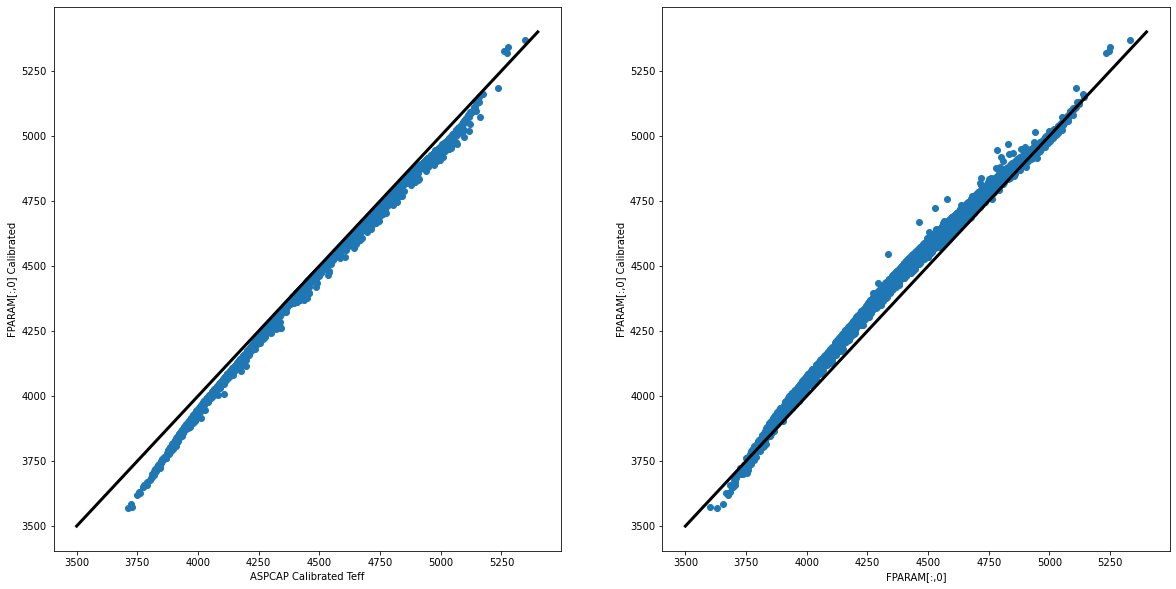

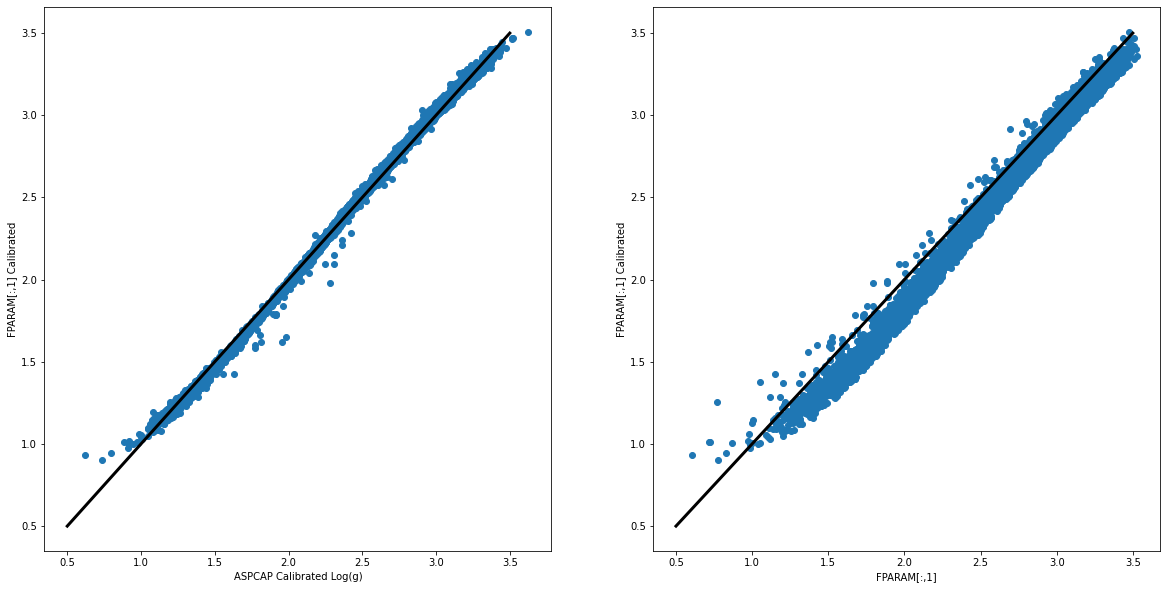

In [171]:
# %matplotlib inline

### Teff
plt.figure(figsize=[20,10])
plt.subplot(121)
plt.scatter(kdr17['TEFF'],teff_cal)
plt.plot([3500,5400],[3500,5400],c='k',lw=3.0)
plt.xlabel(r'ASPCAP Calibrated Teff')
plt.ylabel(r'FPARAM[:,0] Calibrated')

plt.subplot(122)
plt.scatter(kdr17['FPARAM'][:,0],teff_cal)
plt.plot([3500,5400],[3500,5400],c='k',lw=3.0)
plt.xlabel(r'FPARAM[:,0]')
plt.ylabel(r'FPARAM[:,0] Calibrated')
plt.show()

### Log(g)
plt.figure(figsize=[20,10])
plt.subplot(121)
plt.scatter(kdr17['LOGG'],logg_cal)
plt.plot([0.5,3.5],[0.5,3.5],c='k',lw=3.0)
plt.xlabel(r'ASPCAP Calibrated Log(g)')
plt.ylabel(r'FPARAM[:,1] Calibrated')

plt.subplot(122)
plt.scatter(kdr17['FPARAM'][:,1],logg_cal)
plt.plot([0.5,3.5],[0.5,3.5],c='k',lw=3.0)
plt.xlabel(r'FPARAM[:,1]')
plt.ylabel(r'FPARAM[:,1] Calibrated')
plt.show()

# %matplotlib qt5

# Gaia EDR3

In [16]:
gaiaedr3 = fits.getdata('/Users/joshuapovick/Desktop/Research/gaia/GAIAEDR3allStar.fits.gz')

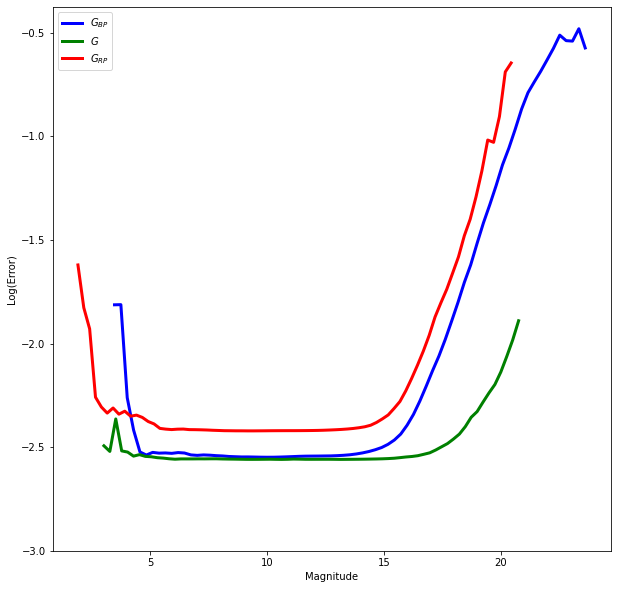

In [17]:
from scipy.stats import binned_statistic, binned_statistic_2d

binnum = 75

### BP
bp_fin = np.where(np.isfinite(gaiaedr3['phot_bp_mean_mag'])==True)

bpmin = min(gaiaedr3['phot_bp_mean_mag'][bp_fin])
bpmax = max(gaiaedr3['phot_bp_mean_mag'][bp_fin])

bpdiff = bpmax-bpmin
bpfluxerr = (2.5*0.434)/gaiaedr3['phot_bp_mean_flux_over_error'][bp_fin]
bpmagerr = np.sqrt((bpfluxerr)**2+0.0027901700**2)

bpbin ,_,_ = binned_statistic(gaiaedr3['phot_bp_mean_mag'][bp_fin],np.log10(bpmagerr),'median',bins=binnum)

### G
g_fin = np.where(np.isfinite(gaiaedr3['phot_g_mean_mag'])==True)

gmin = min(gaiaedr3['phot_g_mean_mag'][g_fin])
gmax = max(gaiaedr3['phot_g_mean_mag'][g_fin])

gdiff = gmax-gmin
gfluxerr = (2.5*0.434)/gaiaedr3['phot_g_mean_flux_over_error'][g_fin]
gmagerr = np.sqrt((gfluxerr)**2+0.0027553202**2)

gbin ,_,_ = binned_statistic(gaiaedr3['phot_g_mean_mag'][g_fin],np.log10(gmagerr),'median',bins=binnum)

### RP 
rp_fin = np.where(np.isfinite(gaiaedr3['phot_rp_mean_mag'])==True)

rpmin = min(gaiaedr3['phot_rp_mean_mag'][rp_fin])
rpmax = max(gaiaedr3['phot_rp_mean_mag'][rp_fin])

rpdiff = rpmax-rpmin
rpfluxerr = (2.5*0.434)/gaiaedr3['phot_rp_mean_flux_over_error'][rp_fin]
rpmagerr = np.sqrt((rpfluxerr)**2+0.0037793818**2)

rpbin ,_,_ = binned_statistic(gaiaedr3['phot_rp_mean_mag'][rp_fin],np.log10(rpmagerr),'median',bins=binnum)

### Plot
plt.figure(figsize=[10,10])
plt.plot(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin,lw=3.0,c='blue',label=r'$G_{BP}$')
plt.plot(np.arange(gmin,gmax,gdiff/binnum),gbin,lw=3.0,c='green',label=r'$G$')
plt.plot(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin,lw=3.0,c='red',label=r'$G_{RP}$')
plt.legend()
plt.ylim(bottom=-3.0)
plt.xlabel('Magnitude')
plt.ylabel('Log(Error)')
plt.savefig('../plots/gaiaerrorcurve.pdf',dpi=300,bbox_inches='tight');

bperrfunc = utils.bspline(np.arange(bpmin,bpmax,bpdiff/binnum),bpbin)
gerrfunc = utils.bspline(np.arange(gmin,gmax,gdiff/binnum),gbin)
rperrfunc = utils.bspline(np.arange(rpmin,rpmax,rpdiff/binnum),rpbin)

### Replace nan's with zeropoint error
bperr = np.nan_to_num(10**bperrfunc(kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG']),nan=0.0027901700)
gerr = np.nan_to_num(10**gerrfunc(kdr17['GAIAEDR3_PHOT_G_MEAN_MAG']),nan=0.0027553202)
rperr = np.nan_to_num(10**rperrfunc(kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG']),nan=0.0037793818)

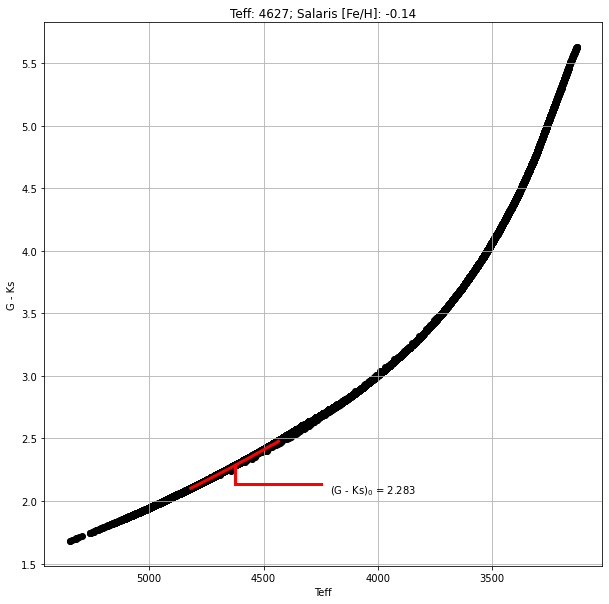

In [18]:
singfeh = massive[np.where(massive['MH']==closest(massive['MH'],-0.14))]

plt.figure(figsize=[10,10])
plt.scatter(10**singfeh['logTe'],singfeh['GEDR3mag']-singfeh['Ksmag'],c='k')

# plt.axvline(4627+200,c='k',ls='--',lw=3.0)
# plt.axvline(4627-200,c='k',ls='--',lw=3.0)

isocut = np.where((singfeh['logTe']>=np.log10(4627-200))&(singfeh['logTe']<=np.log10(4627+200)))
spl = utils.bspline(10**singfeh['logTe'][isocut],(singfeh['GEDR3mag']-singfeh['Ksmag'])[isocut])

plt.plot(np.linspace(4627-200,4627+200),spl(np.linspace(4627-200,4627+200)),c='r',lw=3.0)

plt.plot([4627,4627],[spl(4627),spl(4627)-0.25+0.1],c='r',lw=3.0)
plt.plot([4627,4250],[spl(4627)-0.25+0.1,spl(4627)-0.25+0.1],c='r',lw=3.0)

# plt.axhline(4.5)
# plt.text(4400+400,4.36,'+200 K',rotation=90)
# plt.text(4400,4.45,'-200 K',rotation=90)

plt.gca().invert_xaxis()

plt.grid()

plt.text(4210,spl(4627)-0.32+0.1,'(G - Ks)$_0$ = {:.3f}'.format(spl(4627)))

plt.title(r'Teff: 4627; Salaris [Fe/H]: -0.14')
plt.xlabel(r'Teff')
plt.ylabel(r'G - Ks')
plt.savefig('../plots/ext_schematic.pdf',dpi=300,bbox_inches='tight')
plt.show()

In [20]:
parsec_age = 999999.0*np.ones(len(kdr17))

for i in tqdm(range(len(kdr17))):
    parsec_age[i] = mass_2_age_PARSEC(k674['APOKASC3P_MASS'][i],salfeh[i],massive)

  0%|          | 0/6099 [00:00<?, ?it/s]

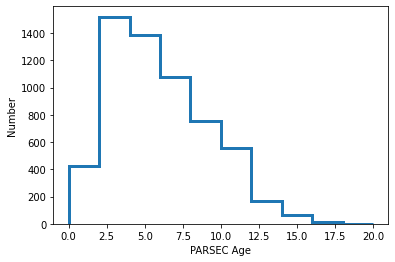

In [21]:
plt.hist(parsec_age,histtype='step',lw=3.0,range=(0,20))
plt.xlabel(r'PARSEC Age')
plt.ylabel(r'Number')
plt.show()

In [69]:
kasc_ext = 999999.0*np.ones((len(kdr17),6))
kasc_ext_err = 999999.0*np.ones((len(kdr17),6))
kasc_age = 999999.0*np.ones(len(kdr17))
kasc_chi = 999999.0*np.ones(len(kdr17))
kasc_rms = 999999.0*np.ones(len(kdr17))
kasc_mass = 999999.0*np.ones(len(kdr17))
# kasc_mass_err = 999999.0*np.ones(len(kdr17))

# for i in tqdm(range(10)):#tqdm_notebook(range(len(kdr17))):
for i in tqdm(range(len(kdr17))):
    
    # Initialize Aetas 
    te = np.array([teff_cal[i],kdr17['TEFF_ERR'][i]])
    
    lg = np.array([logg_cal[i],kdr17['LOGG_ERR'][i]])
    
    ab = np.array([[kdr17['FE_H'][i],apoafe[i]],
                   [kdr17['FE_H_ERR'][i],apoafe_err[i]]]).T
    
    op = np.array([[kdr17['GAIAEDR3_PHOT_BP_MEAN_MAG'][i],
                    kdr17['GAIAEDR3_PHOT_G_MEAN_MAG'][i],
                    kdr17['GAIAEDR3_PHOT_RP_MEAN_MAG'][i],
                    kdr17['J'][i],kdr17['H'][i],kdr17['K'][i]],
                   [bperr[i],gerr[i],rperr[i],kdr17['J_ERR'][i],
                    kdr17['H_ERR'][i],kdr17['K_ERR'][i]]]).T
    
    di = (1/kdr17['GAIAEDR3_PARALLAX'][i])*1000

    CalcAge = Aetas(te,lg,ab,op,di,massive)
    
    exts = CalcAge.extinction()
    kasc_ext[i,:],kasc_ext_err[i,:] = exts[:,0],exts[:,1]
    kasc_age[i],kasc_chi[i],kasc_rms[i] = CalcAge.get_age()
#     kasc_mass[i],kasc_mass_err[i] = CalcAge.get_mass(CalcAge.age)
    kasc_mass[i] = CalcAge.get_mass(CalcAge.age)

  0%|          | 0/6099 [00:00<?, ?it/s]

<ipython-input-68-cdb497111f0d>:65: RuntimeWarning: invalid value encountered in log10
  self.distmod = 5.0*np.log10(distance)-5.0


In [82]:
kasc_ext[:,0]

array([0.02903814, 0.13658658, 0.08223653, ..., 0.58504748, 2.38492238,
       0.29892765])

In [153]:
from astropy.table import Table, Column

cname = Column(kdr17['APOGEE_ID'],name='NAME')

# Age
cage = Column(kasc_age,name='AGE')
cchi = Column(kasc_chi,name='AGE_CHI')
crms = Column(kasc_rms,name='AGE_RMSE')
cpage = Column(parsec_age,name='APOKASC_PARSEC_MASS_DERIV_AGE')

# Extinctions
cabp = Column(kasc_ext[:,0],name='A_BP')
cabp_err = Column(kasc_ext_err[:,0],name='A_BP_ERR')

cag = Column(kasc_ext[:,1],name='A_G')
cag_err = Column(kasc_ext_err[:,1],name='A_G_ERR')

carp = Column(kasc_ext[:,2],name='A_RP')
carp_err = Column(kasc_ext_err[:,2],name='A_RP_ERR')

caj = Column(kasc_ext[:,3],name='A_J')
caj_err = Column(kasc_ext_err[:,3],name='A_J_ERR')

cah = Column(kasc_ext[:,4],name='A_H')
cah_err = Column(kasc_ext_err[:,4],name='A_H_ERR')

cak = Column(kasc_ext[:,5],name='A_K')
cak_err = Column(kasc_ext_err[:,5],name='A_K_ERR')

# Masses
cmass = Column(kasc_mass,name='MASS')

# Make table
agetable = Table([cname,cage,cchi,crms,cpage,cabp,cabp_err,cag,cag_err,carp,carp_err,caj,caj_err,cah,cah_err,
                  cak,cak_err,cmass])
agetable.write('apokasc_rgb_age_ext_mass.fits', format='fits', overwrite=True)

In [154]:
agetab = fits.getdata('apokasc_rgb_age_ext_mass.fits')
agetab.columns

ColDefs(
    name = 'NAME'; format = '30A'
    name = 'AGE'; format = 'D'
    name = 'AGE_CHI'; format = 'D'
    name = 'AGE_RMSE'; format = 'D'
    name = 'APOKASC_PARSEC_MASS_DERIV_AGE'; format = 'D'
    name = 'A_BP'; format = 'D'
    name = 'A_BP_ERR'; format = 'D'
    name = 'A_G'; format = 'D'
    name = 'A_G_ERR'; format = 'D'
    name = 'A_RP'; format = 'D'
    name = 'A_RP_ERR'; format = 'D'
    name = 'A_J'; format = 'D'
    name = 'A_J_ERR'; format = 'D'
    name = 'A_H'; format = 'D'
    name = 'A_H_ERR'; format = 'D'
    name = 'A_K'; format = 'D'
    name = 'A_K_ERR'; format = 'D'
    name = 'MASS'; format = 'D'
)

In [ ]:
# convert_sfdebv(wave,ebv)

In [188]:
ag_sfd = convert_sfdebv(leff['G'],kdr17['SFD_EBV'][ext_fincut])

ag_sfd

array([0.07437616, 0.06942749, 0.07017399, ..., 1.2966856 , 1.3827177 ,
       1.1157693 ], dtype=float32)

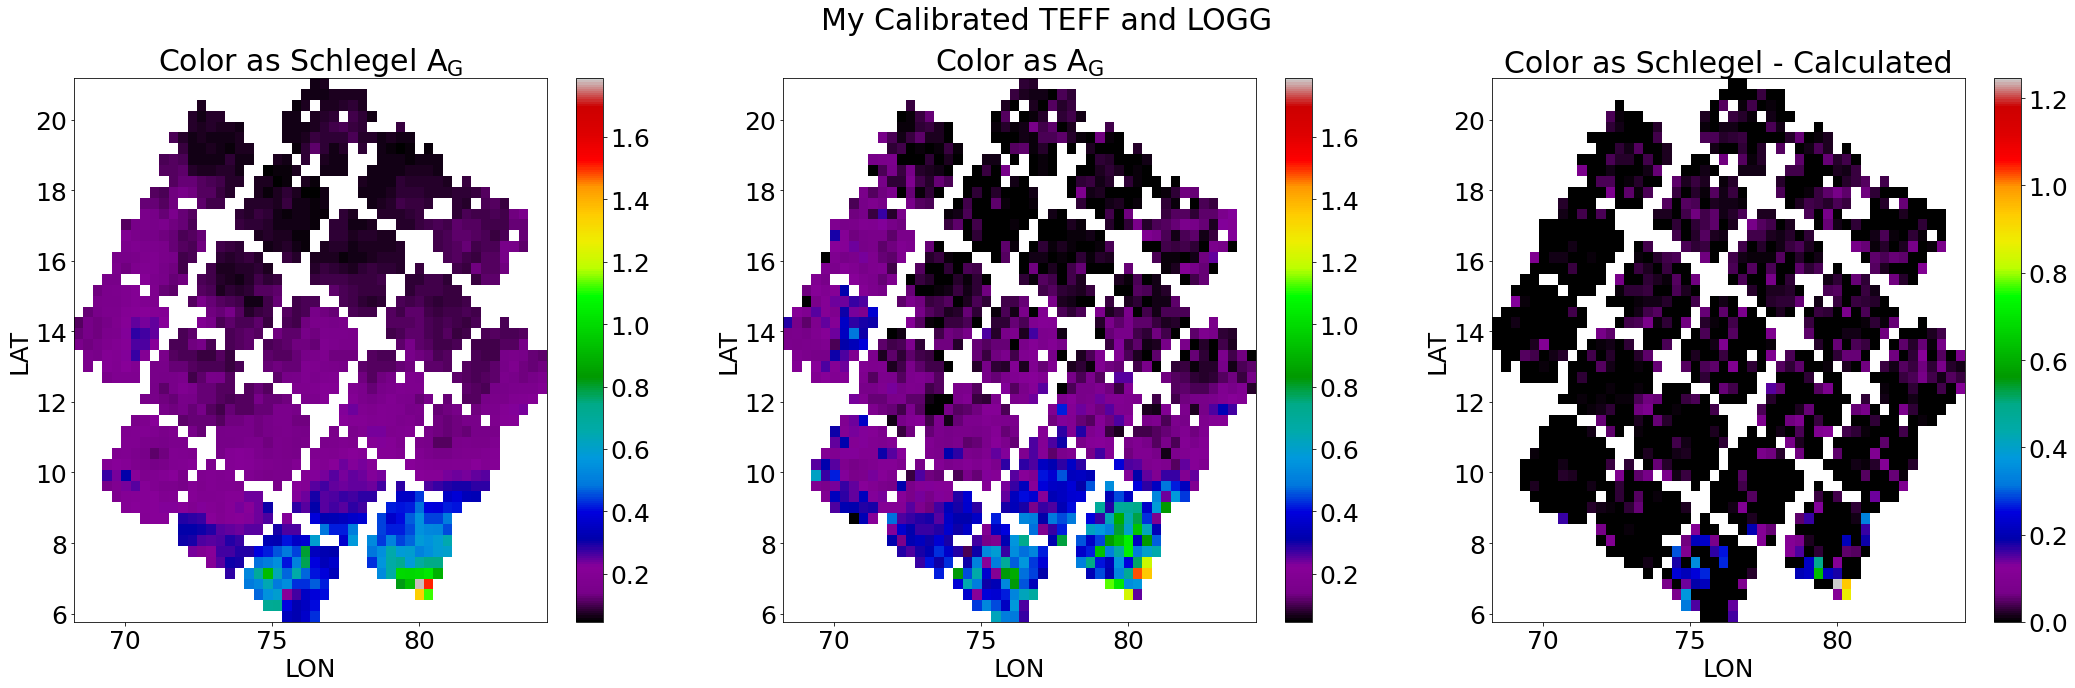

In [195]:
matplotlib.rcParams.update({'font.size': 25})
plt.figure(figsize=[36,10])
plt.subplot(131)
ext_fincut = np.where((np.isfinite(kdr17['SFD_EBV'])==True)&(kdr17['SFD_EBV']>0.))
ext_ret = binned_statistic_2d(kdr17['GLON'][ext_fincut],kdr17['GLAT'][ext_fincut],
                                  convert_sfdebv(leff['G'],kdr17['SFD_EBV'][ext_fincut]),'median',bins=50)
ext_ret.statistic[ext_ret.statistic == 0.0] = np.nan
im = plt.imshow(ext_ret.statistic.T, origin='lower',
                extent=[ext_ret.x_edge[0],ext_ret.x_edge[-1],ext_ret.y_edge[0],ext_ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',
                vmin=np.min(convert_sfdebv(leff['G'],kdr17['SFD_EBV'][ext_fincut])),
                vmax=np.max(convert_sfdebv(leff['G'],kdr17['SFD_EBV'][ext_fincut])))

plt.colorbar()

plt.title(r'Color as Schlegel ${\rm A_G}$')
plt.xlabel(r'LON')
plt.ylabel(r'LAT')

###
plt.subplot(132)
ext_fincut = np.where((np.isfinite(agetab['A_G'])==True)&(agetab['A_G']<100.))
ext_ret = binned_statistic_2d(kdr17['GLON'][ext_fincut],kdr17['GLAT'][ext_fincut],
                                  agetab['A_G'][ext_fincut],'median',
                                  bins=50)
ext_ret.statistic[ext_ret.statistic == 0.0] = np.nan
im = plt.imshow(ext_ret.statistic.T, origin='lower',
                extent=[ext_ret.x_edge[0],ext_ret.x_edge[-1],ext_ret.y_edge[0],ext_ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',
                vmin=np.min(convert_sfdebv(leff['G'],kdr17['SFD_EBV'][ext_fincut])),
                vmax=np.max(convert_sfdebv(leff['G'],kdr17['SFD_EBV'][ext_fincut])))

plt.colorbar()

plt.title(r'Color as ${\rm A_G}$')
plt.xlabel(r'LON')
plt.ylabel(r'LAT')

###
plt.subplot(133)
ext_fincut = np.where((np.isfinite(kdr17['SFD_EBV'])==True)&(kdr17['SFD_EBV']>0.)&
                      (np.isfinite(agetab['A_G'])==True)&(agetab['A_G']<100.))
ext_ret = binned_statistic_2d(kdr17['GLON'][ext_fincut],kdr17['GLAT'][ext_fincut],
                                  convert_sfdebv(leff['G'],kdr17['SFD_EBV'][ext_fincut])-agetab['A_G'][ext_fincut],'median',
                                  bins=50)
ext_ret.statistic[ext_ret.statistic == 0.0] = np.nan
im = plt.imshow(ext_ret.statistic.T, origin='lower',
                extent=[ext_ret.x_edge[0],ext_ret.x_edge[-1],ext_ret.y_edge[0],ext_ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral',vmin=0)

plt.colorbar()

plt.title(r'Color as Schlegel - Calculated')
plt.xlabel(r'LON')
plt.ylabel(r'LAT')

plt.suptitle(r'My Calibrated TEFF and LOGG')
plt.savefig('mycal_teff_logg_ext_map.pdf',bbox_inches='tight')
plt.show()

(0.0, 2.5)

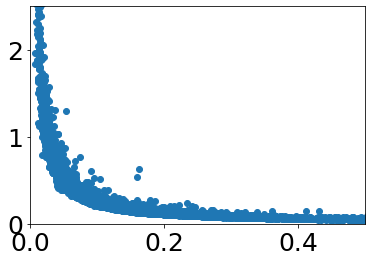

In [202]:
plt.scatter(agetab['A_G'],agetab['A_G_ERR']/agetab['A_G'])
plt.xlim(0,0.5)
plt.ylim(0,2.5)

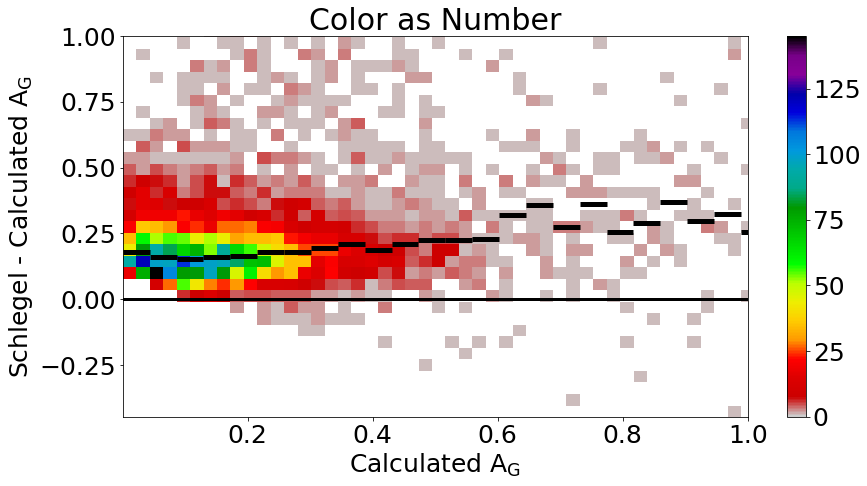

Median Residual: 0.174 +/- 0.090


In [161]:
plt.figure(figsize=[14,7])

### 2D hist
ext_fincut = np.where((np.isfinite(kdr17['SFD_EBV'])==True)&(kdr17['SFD_EBV']>0.)&
                      (np.isfinite(agetab['A_G'])==True)&(agetab['A_G']<100.))

ext_resid_ret = binned_statistic_2d(agetab['A_G'][ext_fincut],(kdr17['SFD_EBV']/ebv_ag-agetab['A_G'])[ext_fincut],
                                    agetab['A_G'][ext_fincut],'count',bins=100)
ext_resid_ret.statistic[ext_resid_ret.statistic == 0.0] = np.nan


### Medians
meds,edgs,_ = binned_statistic(agetab['A_G'][ext_fincut],(kdr17['SFD_EBV']/ebv_ag-agetab['A_G'])[ext_fincut],
                               'median',bins=50)

im = plt.imshow(ext_resid_ret.statistic.T, origin='lower',
                extent=[ext_resid_ret.x_edge[0],ext_resid_ret.x_edge[-1],ext_resid_ret.y_edge[0],ext_resid_ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral_r',vmin=0)
plt.colorbar()

plt.hlines(meds,edgs[:-1],edgs[1:], colors='k', lw=5.)

plt.axhline(0.0,c='k',lw=3.0)

plt.ylim(top=1.0)
plt.xlim(right=1.0)

plt.title(r'Color as Number')
plt.ylabel(r'Schlegel - Calculated ${\rm A_G}$')
plt.xlabel(r'Calculated ${\rm A_G}$')

plt.show()

print(r'Median Residual: {:.3f} +/- {:.3f}'.format(np.median((kdr17['SFD_EBV']/ebv_ag-agetab['A_G'])[ext_fincut]),
                                    utils.mad((kdr17['SFD_EBV']/ebv_ag-agetab['A_G'])[ext_fincut])))

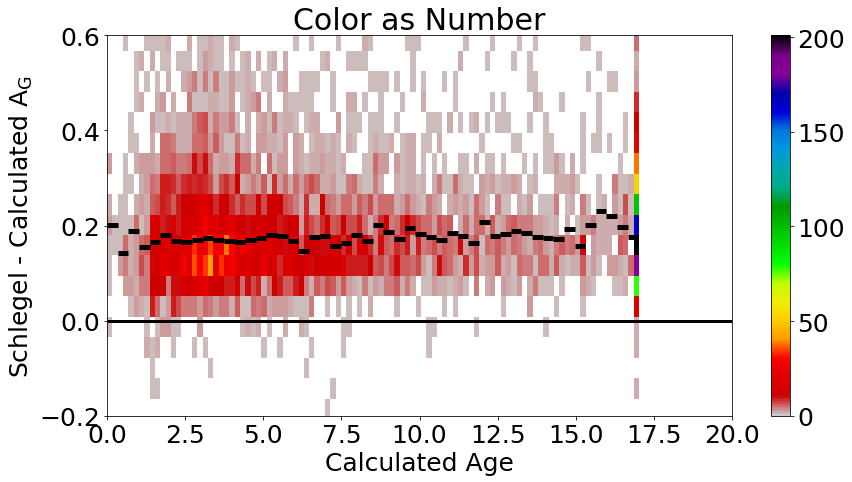

In [163]:
plt.figure(figsize=[14,7])

### 2D hist
ext_fincut = np.where((np.isfinite(kdr17['SFD_EBV'])==True)&(kdr17['SFD_EBV']>0.)&
                      (np.isfinite(agetab['AGE'])==True)&(agetab['AGE']<100.)&
                      (np.isfinite(agetab['A_G'])==True)&(agetab['A_G']<100.))

ext_resid_ret = binned_statistic_2d(agetab['AGE'][ext_fincut],(kdr17['SFD_EBV']/ebv_ag-agetab['A_G'])[ext_fincut],
                                    agetab['AGE'][ext_fincut],'count',bins=100)
ext_resid_ret.statistic[ext_resid_ret.statistic == 0.0] = np.nan


### Medians
meds,edgs,_ = binned_statistic(agetab['AGE'][ext_fincut],(kdr17['SFD_EBV']/ebv_ag-agetab['A_G'])[ext_fincut],
                               'median',bins=50)

im = plt.imshow(ext_resid_ret.statistic.T, origin='lower',
                extent=[ext_resid_ret.x_edge[0],ext_resid_ret.x_edge[-1],ext_resid_ret.y_edge[0],ext_resid_ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='nipy_spectral_r',vmin=0)
plt.colorbar()

plt.hlines(meds,edgs[:-1],edgs[1:], colors='k', lw=5.)

plt.axhline(0.0,c='k',lw=3.0)

plt.ylim(-0.2,0.6)
plt.xlim(right=20.0)

plt.title(r'Color as Number')
plt.ylabel(r'Schlegel - Calculated ${\rm A_G}$')
plt.xlabel(r'Calculated Age')

plt.show()

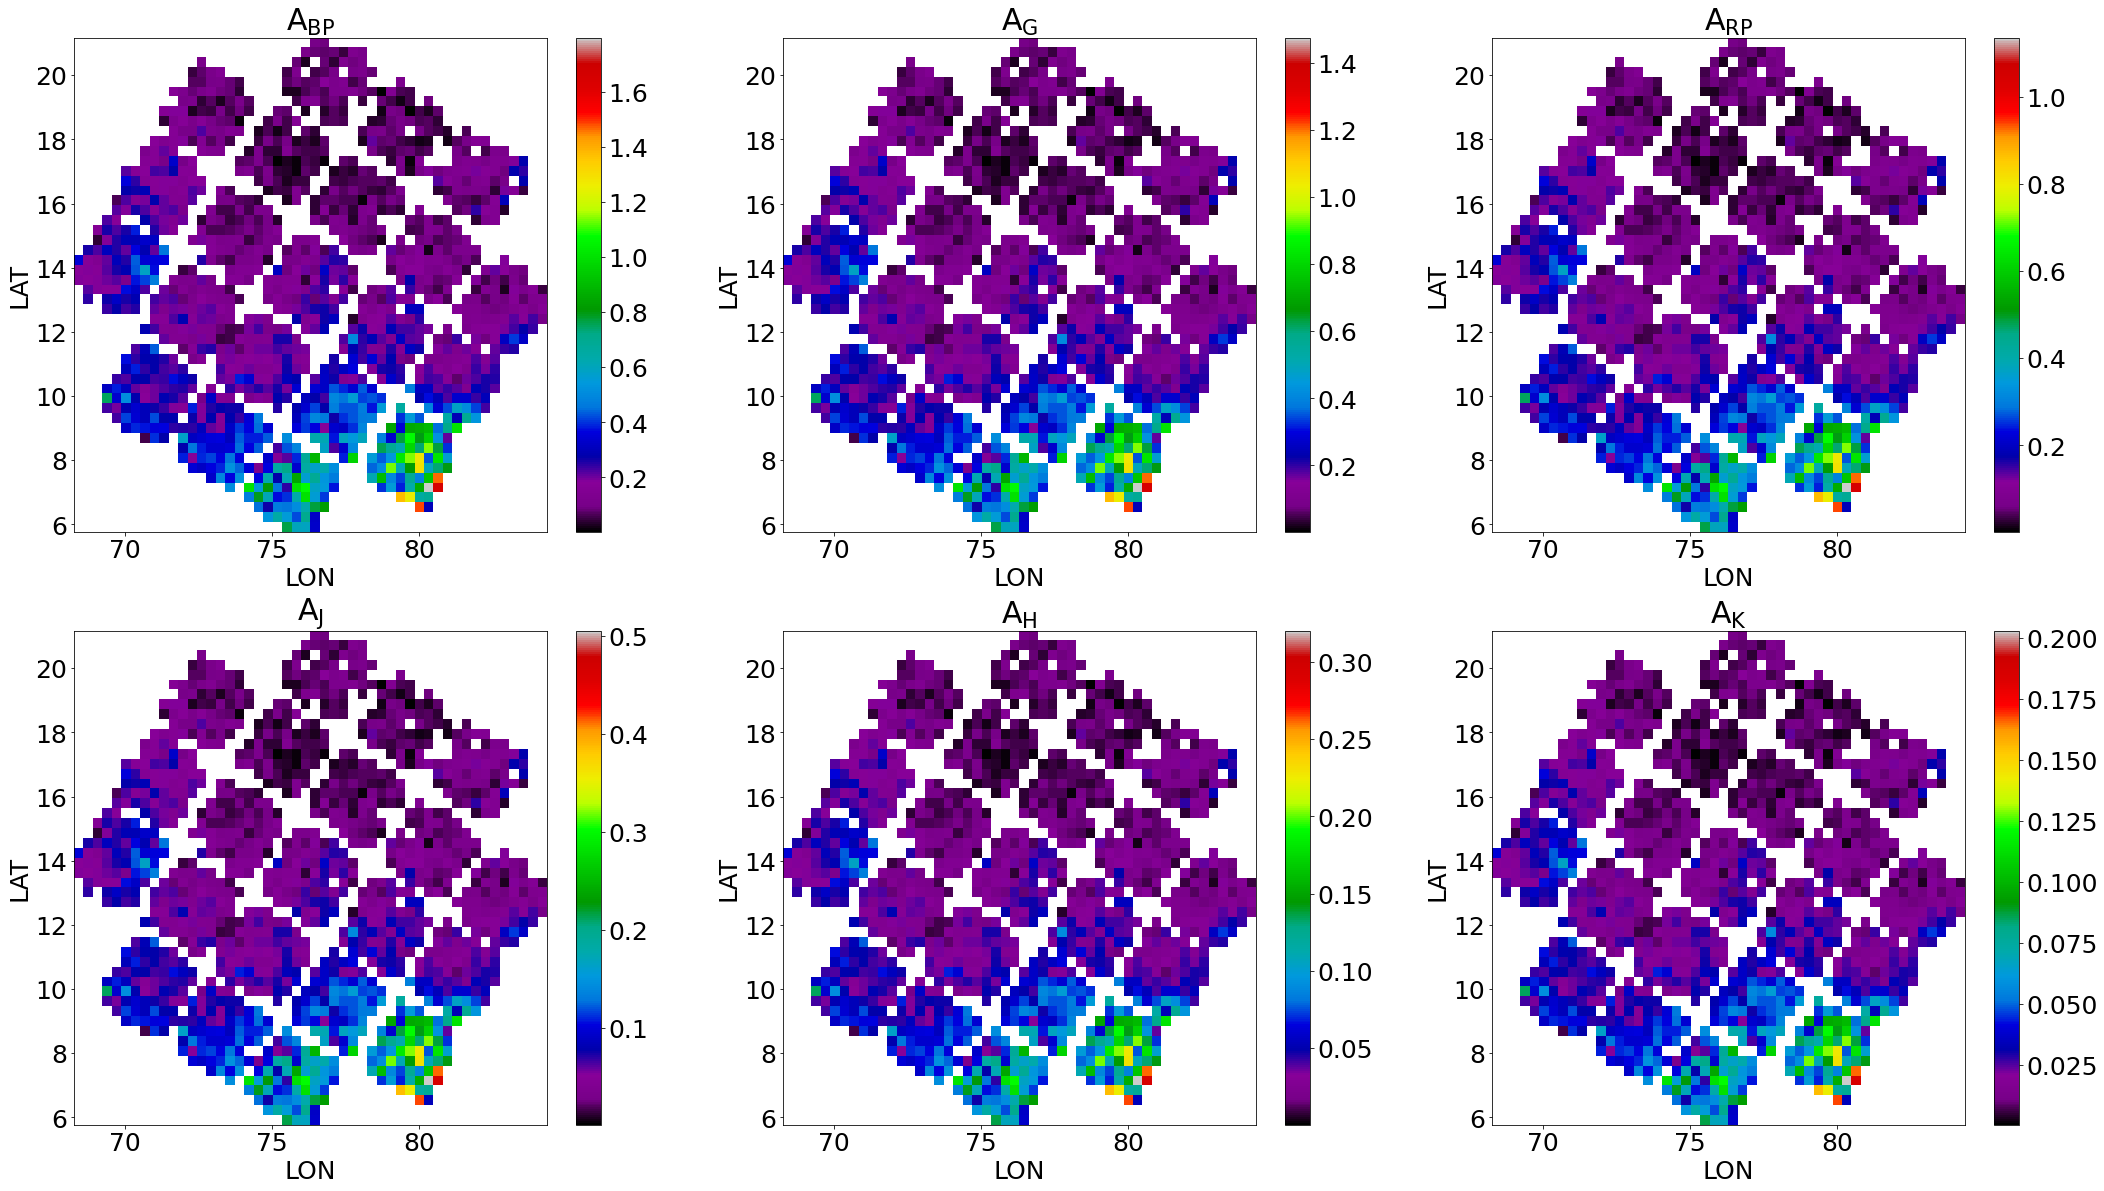

#######################################


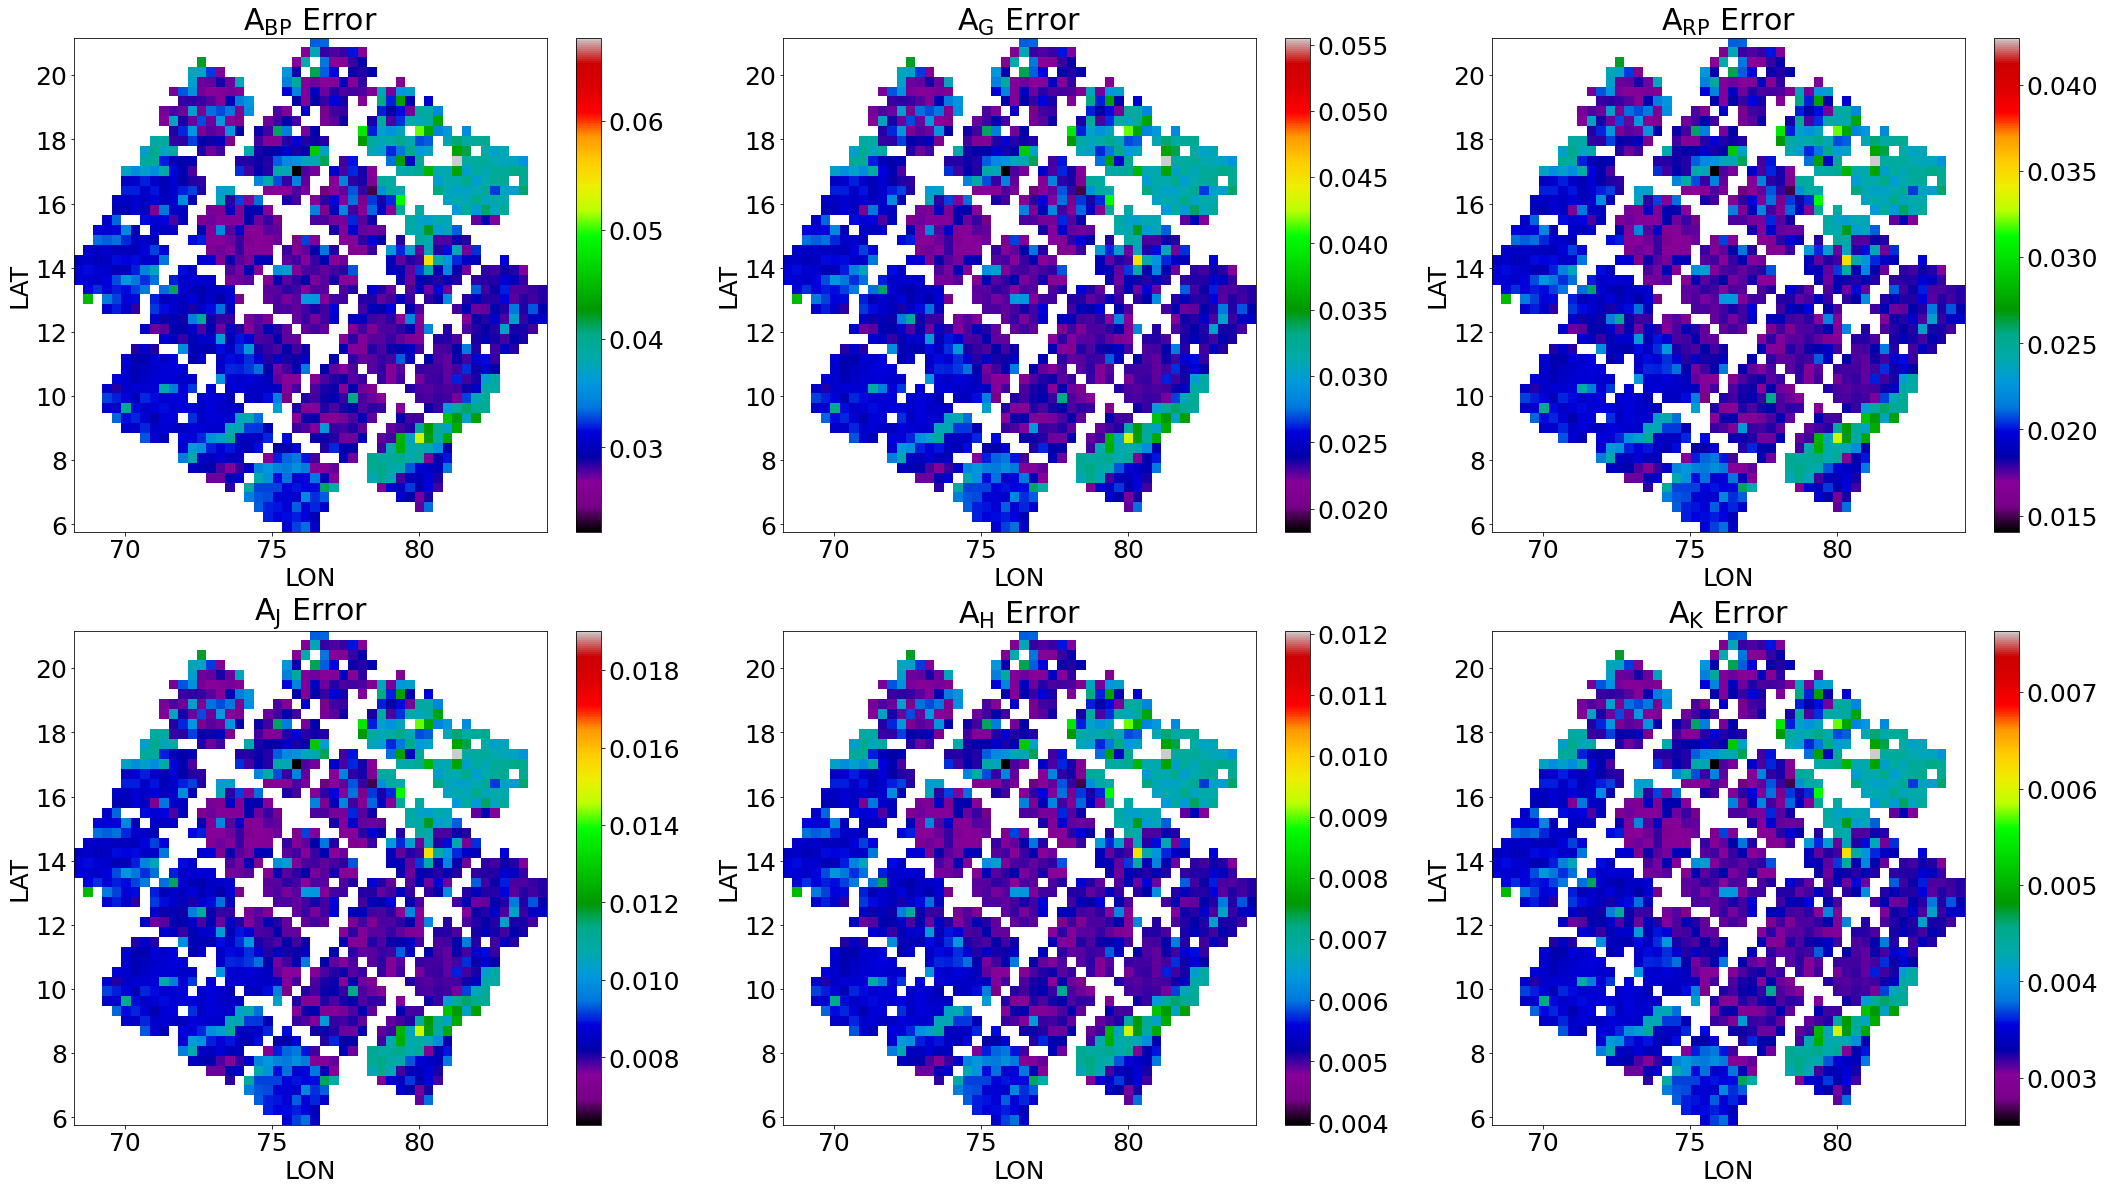

In [130]:
exts=np.array([['A_BP','A_GP','A_RP'],['A_J','A_H','A_K']])
exts_titles = np.array([[r'${\rm A_{BP}}$',r'${\rm A_{G}}$',r'${\rm A_{RP}}$'],
                        [r'${\rm A_{J}}$',r'${\rm A_{H}}$',r'${\rm A_{K}}$']])

fig,ax = plt.subplots(2,3,figsize=[36,20])
for i in range(2):
    for j in range(3):
        ext_fincut = np.where((np.isfinite(agetab[exts[i,j]])==True)&(agetab[exts[i,j]]<100.))
        ext_ret = binned_statistic_2d(kdr17['GLON'][ext_fincut],kdr17['GLAT'][ext_fincut],
                                  agetab[exts[i,j]][ext_fincut],'median',bins=50)
        ext_ret.statistic[ext_ret.statistic == 0.0] = np.nan
        
        im = ax[i,j].imshow(ext_ret.statistic.T, origin='lower',
                            extent=[ext_ret.x_edge[0],ext_ret.x_edge[-1],ext_ret.y_edge[0],ext_ret.y_edge[-1]],
                            aspect='auto',interpolation='nearest',cmap='nipy_spectral')
        
        plt.colorbar(im,ax=ax[i,j])
        
        ax[i,j].set_title(r'{}'.format(exts_titles[i,j]))
        ax[i,j].set_xlabel(r'LON')
        ax[i,j].set_ylabel(r'LAT')
        
plt.show()

print('#######################################')

fig,ax = plt.subplots(2,3,figsize=[36,20])
for i in range(2):
    for j in range(3):
        ext_fincut = np.where((np.isfinite(agetab[exts[i,j]+'_ERR'])==True)&(agetab[exts[i,j]+'_ERR']<100.))
        ext_ret = binned_statistic_2d(kdr17['GLON'][ext_fincut],kdr17['GLAT'][ext_fincut],
                                  agetab[exts[i,j]+'_ERR'][ext_fincut],'median',bins=50)
        ext_ret.statistic[ext_ret.statistic == 0.0] = np.nan
        
        im = ax[i,j].imshow(ext_ret.statistic.T, origin='lower',
                            extent=[ext_ret.x_edge[0],ext_ret.x_edge[-1],ext_ret.y_edge[0],ext_ret.y_edge[-1]],
                            aspect='auto',interpolation='nearest',cmap='nipy_spectral')
        
        plt.colorbar(im,ax=ax[i,j])
        
        ax[i,j].set_title(r'{} Error'.format(exts_titles[i,j]))
        ax[i,j].set_xlabel(r'LON')
        ax[i,j].set_ylabel(r'LAT')
        
plt.show()

In [127]:
agetab[exts[i,j]+'_ERR']

array([0.02224349, 0.04391808, 0.04019865, ..., 0.02729659, 0.02771842,
       0.03346072])

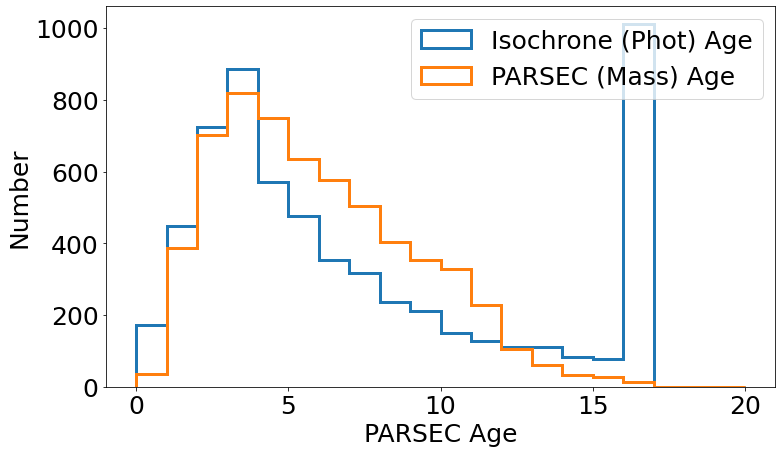

In [76]:
plt.figure(figsize=[12,7])
plt.hist(kasc_age,range=(0,20),histtype='step',lw=3.0,label='Isochrone (Phot) Age',bins=20)
plt.hist(parsec_age,histtype='step',lw=3.0,range=(0,20),label='PARSEC (Mass) Age',bins=20)
plt.legend()
plt.xlabel(r'PARSEC Age')
plt.ylabel(r'Number')
plt.show()

In [103]:
print('ratio: ',len(np.squeeze(np.where(agetab['AGE']>16.)))/len(agetab))
print('Grid Edge: ',len(np.squeeze(np.where(agetab['AGE']>16.))))
print('Total: ',len(agetab))
print('Good: ',len(agetab)-len(np.squeeze(np.where(agetab['AGE']>16.))))

ratio:  0.17150352516806033
Grid Edge:  1046
Total:  6099
Good:  5053


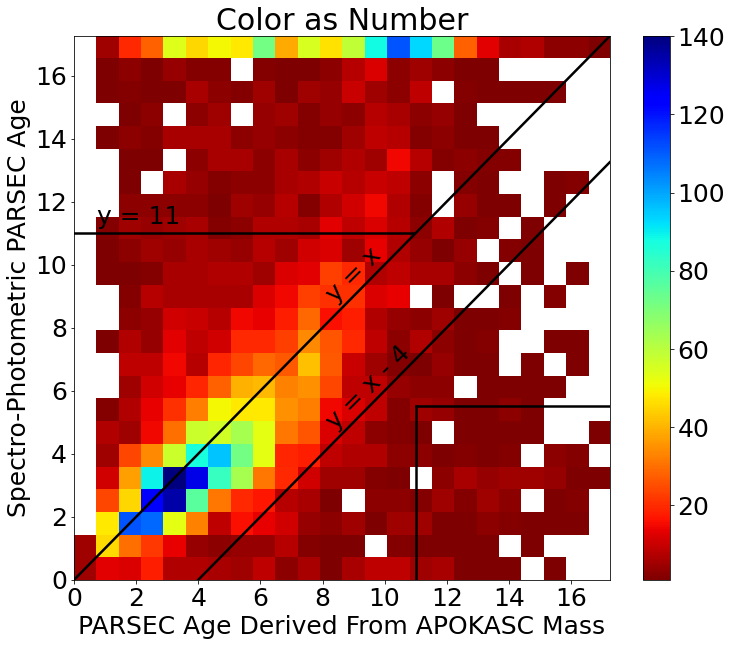

In [96]:
# fincut = np.where((np.isfinite(apodr3['logg_gspphot'])==True)&(np.isfinite(apogee_cal_table['LOGG'])==True))

# ret = binned_statistic_2d(apodr3['logg_gspphot'][fincut],apogee_cal_table['LOGG'][fincut],
#                           apodr3['logg_gspphot'][fincut],'count',bins=50)

# ret.statistic[ret.statistic == 0.0] = np.nan

# im = plt.imshow(ret.statistic.T, origin='lower',
#                     extent=[ret.x_edge[0],ret.x_edge[-1],ret.y_edge[0],ret.y_edge[-1]],
#                     aspect='auto',interpolation='nearest',cmap='jet')

# plt.colorbar()

plt.figure(figsize=[12,10])
xmax = 18
ymax = 18
nbins = 25

age2age_fincut = np.where((np.isfinite(agetab['AGE'])==True)&(agetab['AGE']<100.)&
                         (np.isfinite(agetab['APOKASC_PARSEC_MASS_DERIV_AGE'])==True)&
                         (agetab['APOKASC_PARSEC_MASS_DERIV_AGE']<100.))

age2age_ret = binned_statistic_2d(agetab['APOKASC_PARSEC_MASS_DERIV_AGE'],agetab['AGE'],
                                  agetab['APOKASC_PARSEC_MASS_DERIV_AGE'],'count',
                                  bins=[np.arange(0,xmax,xmax/nbins),np.arange(0,ymax,ymax/25)])

age2age_ret.statistic[age2age_ret.statistic == 0.0] = np.nan

im = plt.imshow(age2age_ret.statistic.T, origin='lower',
                extent=[age2age_ret.x_edge[0],age2age_ret.x_edge[-1],
                        age2age_ret.y_edge[0],age2age_ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='jet_r')

plt.colorbar()

plt.plot([0,18],[0,18],lw=2.5,c='k')
plt.plot([4,17.25],[0,13.25],lw=2.5,c='k')
plt.plot([0,10.95],[11,11],lw=2.5,c='k')

plt.plot([11,11],[0,5.5],c='k',lw=2.5)
plt.plot([11,18],[5.5,5.5],c='k',lw=2.5)

plt.text(8,8.8,'y = x',rotation=45)
plt.text(8,4.8,'y = x - 4',rotation=45)
plt.text(0.75,11.3,'y = 11')

plt.xlim(0,17.25)
plt.ylim(0,17.25)

plt.xticks(np.arange(0,17)[::2],np.arange(0,17)[::2].astype('str'))

plt.title(r'Color as Number')
plt.xlabel(r'PARSEC Age Derived From APOKASC Mass')
plt.ylabel(r'Spectro-Photometric PARSEC Age')

plt.show()

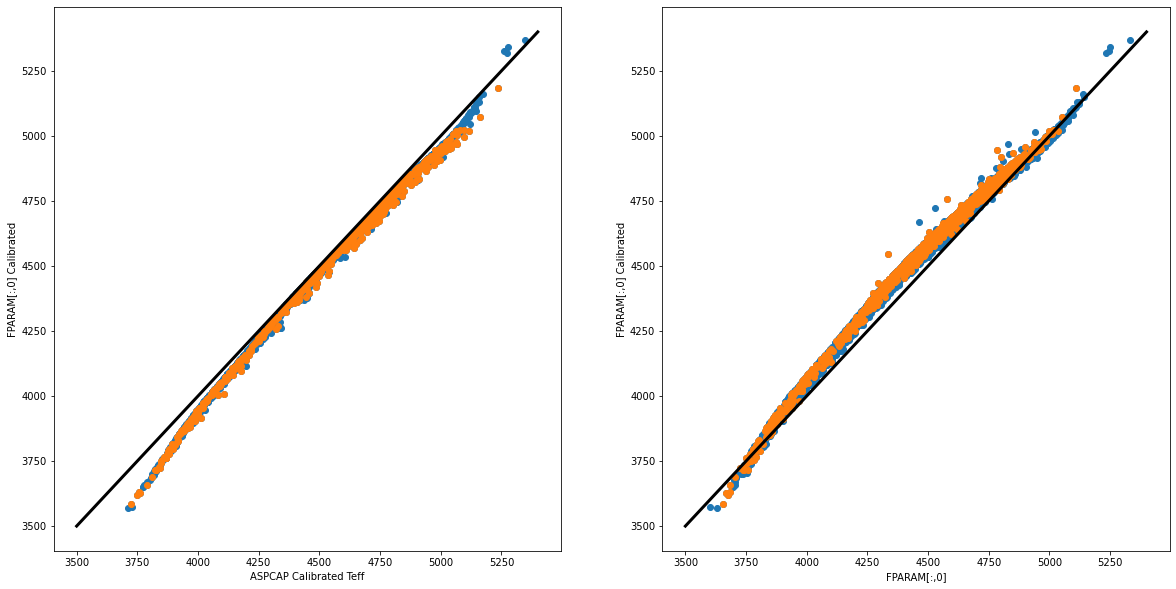

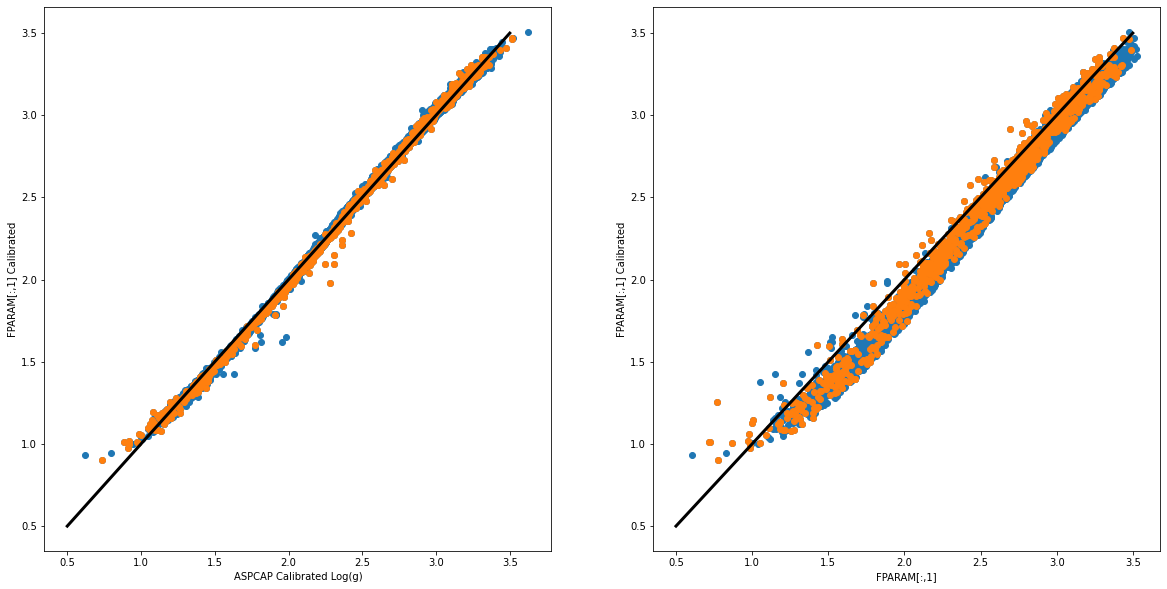

In [175]:
gridedge = np.where(agetab['AGE']>16.)

### Teff
plt.figure(figsize=[20,10])
plt.subplot(121)
plt.scatter(kdr17['TEFF'],teff_cal)
plt.scatter(kdr17['TEFF'][gridedge],teff_cal[gridedge])
plt.plot([3500,5400],[3500,5400],c='k',lw=3.0)
plt.xlabel(r'ASPCAP Calibrated Teff')
plt.ylabel(r'FPARAM[:,0] Calibrated')

plt.subplot(122)
plt.scatter(kdr17['FPARAM'][:,0],teff_cal)
plt.scatter(kdr17['FPARAM'][:,0][gridedge],teff_cal[gridedge])
plt.plot([3500,5400],[3500,5400],c='k',lw=3.0)
plt.xlabel(r'FPARAM[:,0]')
plt.ylabel(r'FPARAM[:,0] Calibrated')
plt.show()

### Log(g)
plt.figure(figsize=[20,10])
plt.subplot(121)
plt.scatter(kdr17['LOGG'],logg_cal)
plt.scatter(kdr17['LOGG'][gridedge],logg_cal[gridedge])
plt.plot([0.5,3.5],[0.5,3.5],c='k',lw=3.0)
plt.xlabel(r'ASPCAP Calibrated Log(g)')
plt.ylabel(r'FPARAM[:,1] Calibrated')

plt.subplot(122)
plt.scatter(kdr17['FPARAM'][:,1],logg_cal)
plt.scatter(kdr17['FPARAM'][:,1][gridedge],logg_cal[gridedge])
plt.plot([0.5,3.5],[0.5,3.5],c='k',lw=3.0)
plt.xlabel(r'FPARAM[:,1]')
plt.ylabel(r'FPARAM[:,1] Calibrated')
plt.show()

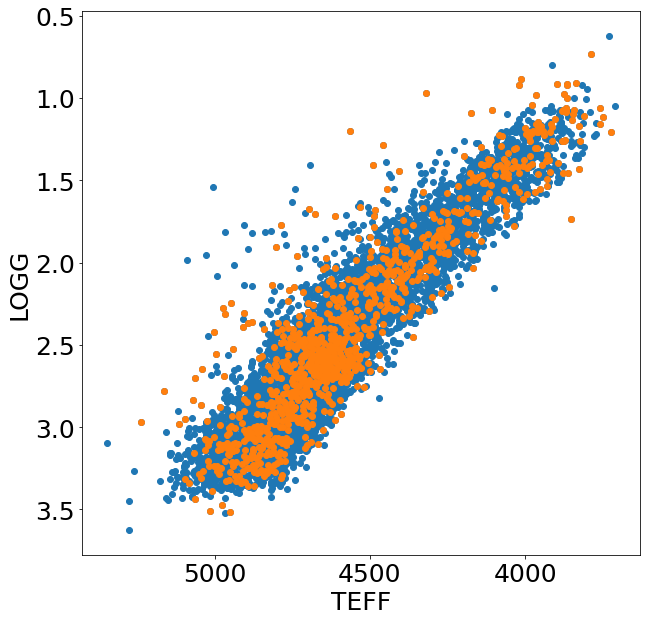

In [204]:
plt.figure(figsize=[10,10])
plt.scatter(kdr17['TEFF'],kdr17['LOGG'])
plt.scatter(kdr17['TEFF'][gridedge],kdr17['LOGG'][gridedge])

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel(r'TEFF')
plt.ylabel(r'LOGG')

plt.show()

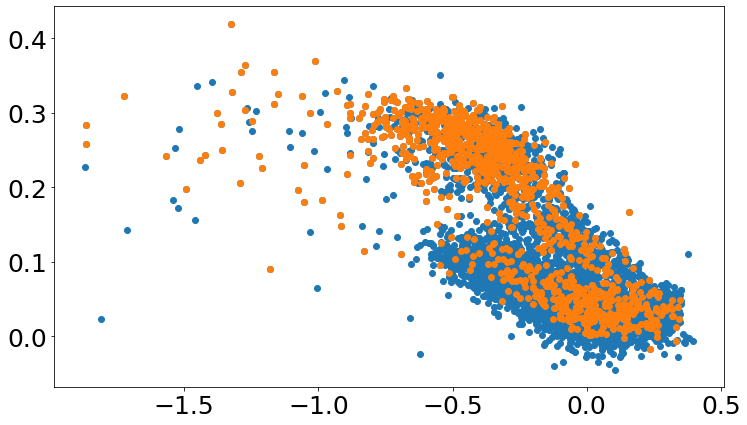

In [213]:
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FE_H'],apoafe)
plt.scatter(kdr17['FE_H'][gridedge],apoafe[gridedge])
# plt.ylim(0,20)

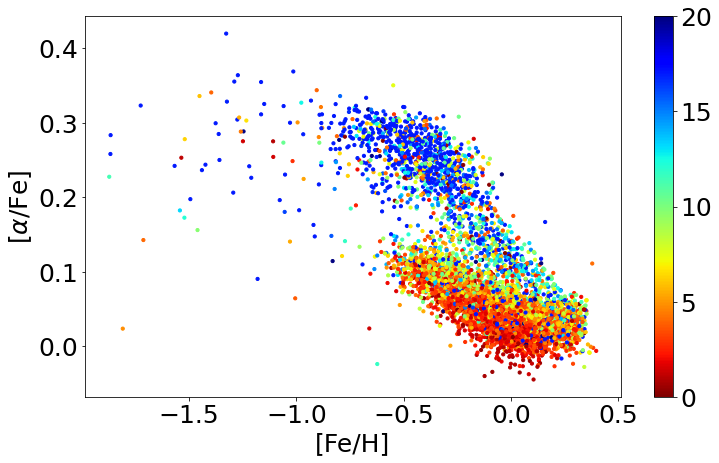

In [225]:
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FE_H'],apoafe,c=agetab['AGE'],cmap='jet_r',vmax=20,vmin=0,s=10)

plt.colorbar()

plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[$\alpha$/Fe]')

plt.show()

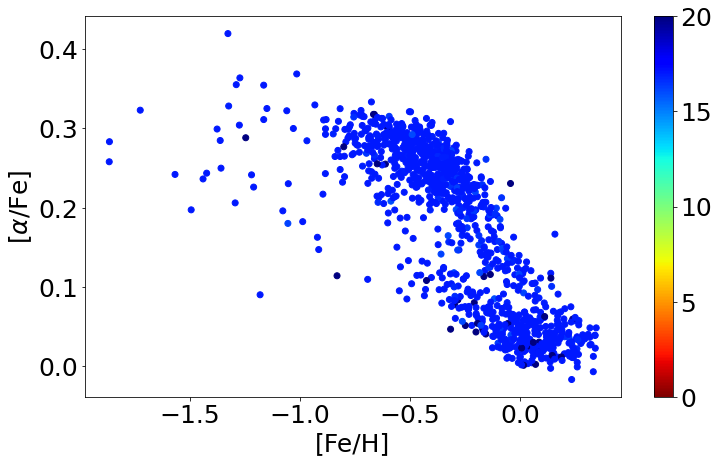

In [223]:
plt.figure(figsize=[12,7])
plt.scatter(kdr17['FE_H'][gridedge],apoafe[gridedge],c=agetab['AGE'][gridedge],cmap='jet_r',vmax=20,vmin=0)

plt.colorbar()

plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[$\alpha$/Fe]')

plt.show()

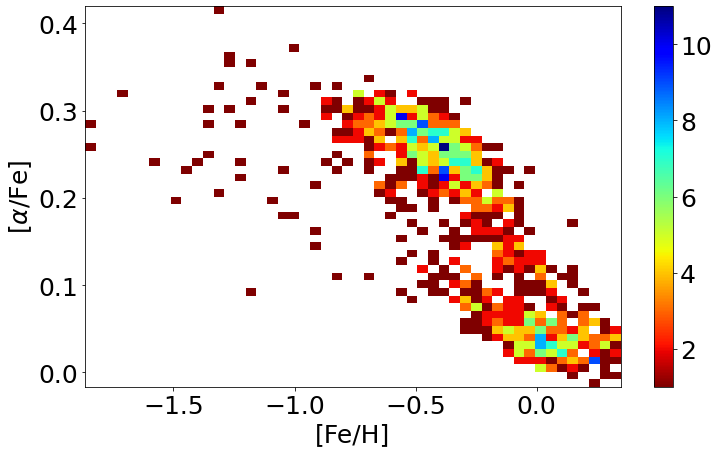

In [218]:
afe_feh_fincut = np.where((np.isfinite(kdr17['FE_H'][gridedge])==True)&
                          (kdr17['FE_H'][gridedge]>-10.)&(np.isfinite(apoafe[gridedge])==True)&
                          (np.isfinite(apoafe[gridedge])==True)&(apoafe[gridedge]>-10.))

afe_feh_ret = binned_statistic_2d(kdr17['FE_H'][gridedge][afe_feh_fincut],apoafe[gridedge][afe_feh_fincut],
                                  kdr17['FE_H'][gridedge][afe_feh_fincut],'count',bins=50)

afe_feh_ret.statistic[afe_feh_ret.statistic == 0.0] = np.nan

plt.figure(figsize=[12,7])
im = plt.imshow(afe_feh_ret.statistic.T, origin='lower',
                extent=[afe_feh_ret.x_edge[0],afe_feh_ret.x_edge[-1],
                        afe_feh_ret.y_edge[0],afe_feh_ret.y_edge[-1]],
                aspect='auto',interpolation='nearest',cmap='jet_r')

plt.colorbar()

plt.xlabel(r'[Fe/H]')
plt.ylabel(r'[$\alpha$/Fe]')

plt.show()